Florent Giauna (AMSD) et Zewei Lin (MLSD)

Appentissage supervisé pour des données avec classes déséquilibrées

Séance 1 - Analyse exploratoire des données déséquilibrées

In [1]:
#Librairies
import itertools
import pandas as pd

#Graphiques
import matplotlib.pyplot as plt
import seaborn as sns

#Pré-traitement
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

#Statistiques
import scipy.stats as ss
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

In [116]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# Dataset : Credit fraud

### Quelles sont les dimensions du jeu de données, existe-t’il des valeurs manquantes ou des attributs constants?

In [3]:
#Chargement des données 
df = pd.read_csv('data/creditcard.csv')

In [4]:
#Affichage des premières lignes
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [5]:
#Affichage du nombre de dimensions
print('Le dataset est de dimension', df.columns.size)

Le dataset est de dimension 31


In [6]:
#Affichage du nombre de valeurs NA
print('Le dataset contient', df.isna().sum().sum(), 'valeurs NA')

Le dataset contient 0 valeurs NA


In [7]:
#Affichage des statistiques basiques pour toutes les colonnes
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

Il n'y a pas d'attribut constant puisque tous ont au moins 2 valeurs différentes.

### Affichez à l’aide d'un graphe adapté la proportion d’individus qui ont churné

In [8]:
#Distribution des classes
class_counts = df.groupby('Class').size()
class_counts

Class
0    284315
1       492
dtype: int64

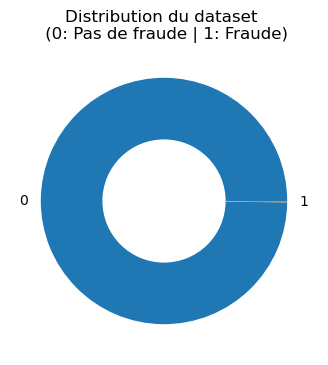

In [9]:
#Comparaison des populations des deux classes à l'aide d'un graphique
fig, ax = plt.subplots(figsize=(4, 4))
#Graphique
ax.pie(x=class_counts, 
       labels=class_counts.index, 
       wedgeprops={"width": 0.5})
#Titre
ax.set_title('Distribution du dataset \n (0: Pas de fraude | 1: Fraude)')
#Affichage
plt.show()

In [10]:
#Affichage de la proportion des observations correspondant à une fraude
print('Les fraudes représentent seulement', round(class_counts[1]/len(df) * 100,2), '% du dataset')

Les fraudes représentent seulement 0.17 % du dataset


### Pour chaque variable catégorielle, affichez à l’aide un graphe adapté la proportion de churn vs. non churn

Ce jeu de données n'a pas de variable catégorielle

### Pour chaque variable numérique, affichez séparemment à l’aide un graphe adapté (eg. histogramme) les valeurs pour les populations churn & non churn

Les distributions étant très déséquilibrées, il faut créer des graphiques différents pour chaque valeur de la variable à prédire. Autrement les valeurs de la classe minoritaire ne sont pas visibles. 

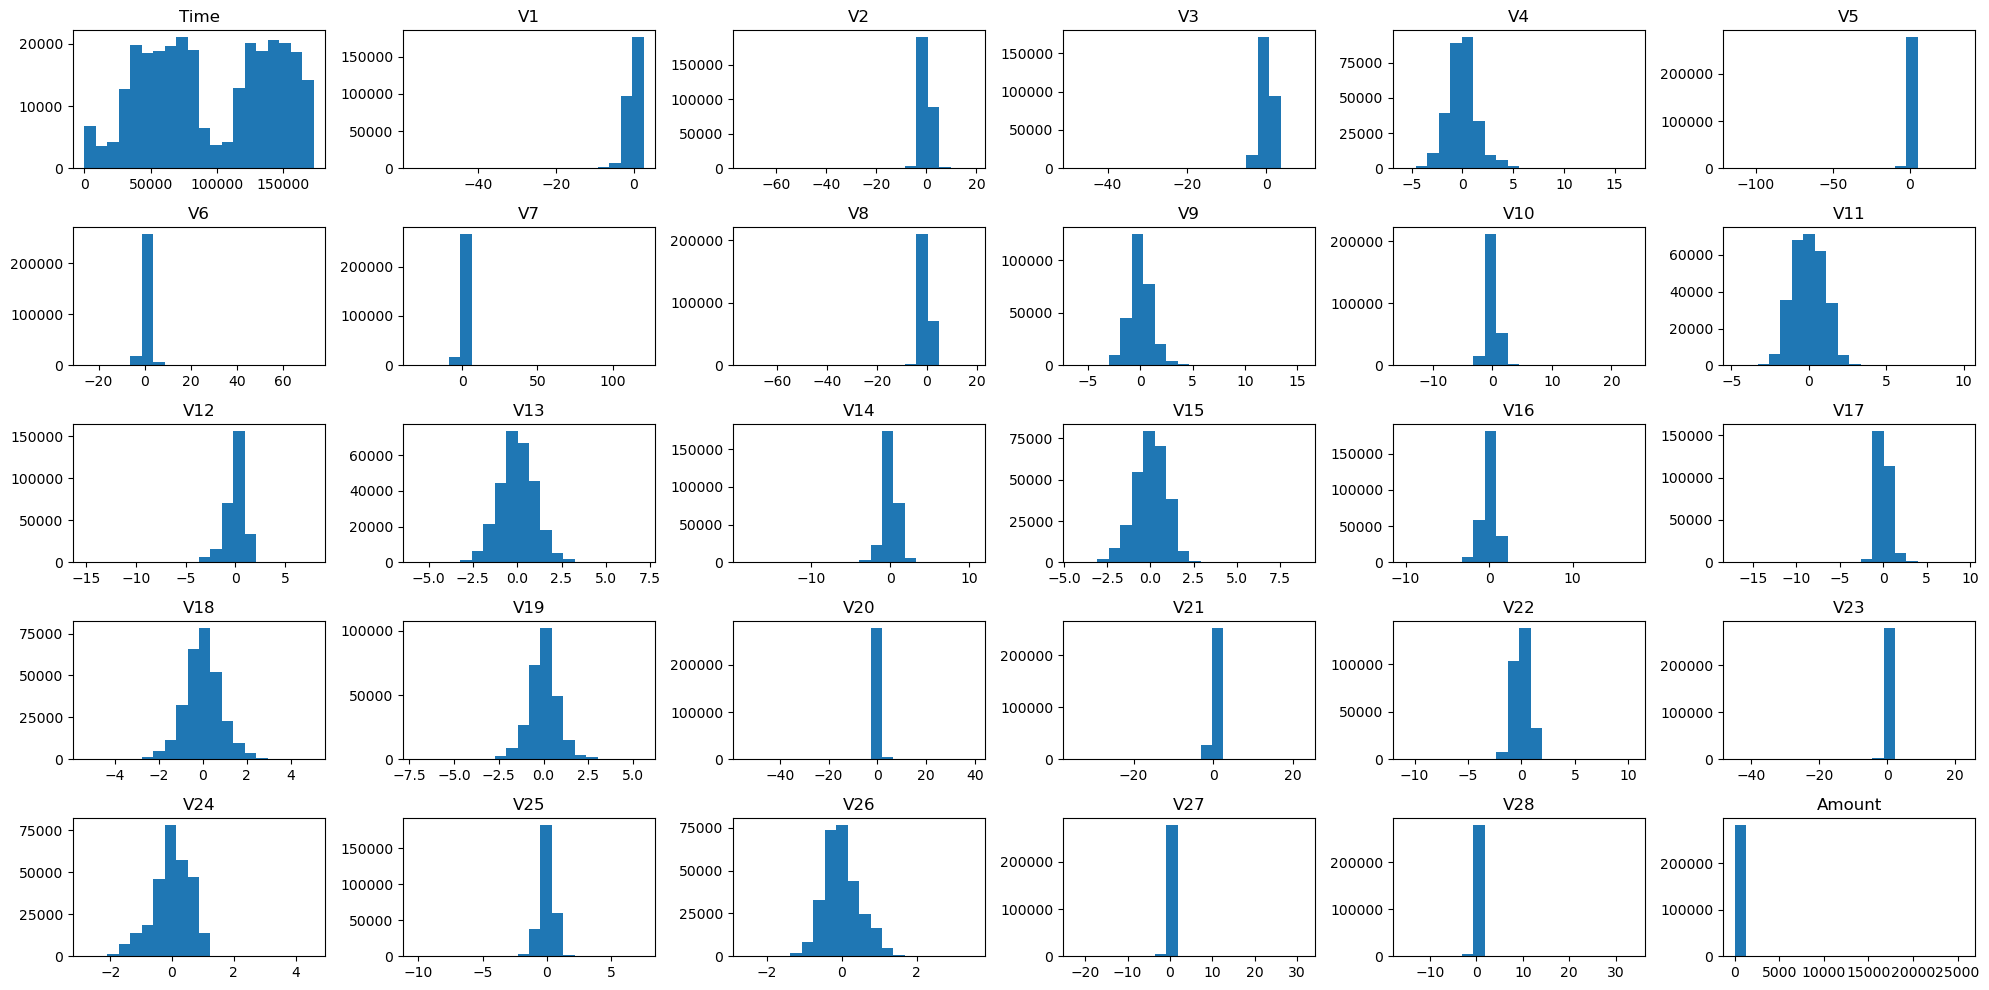

In [11]:
#Dataframe contenant uniquement les observations non classées comme fraude
df0 = df.loc[df['Class']==0]
df0 = df0.drop('Class', axis=1)

#Création des histogrammes pour les variables numériques
df0.hist(grid=False, figsize=(20,10), layout=(5,6), bins=20)
plt.tight_layout()
plt.show()

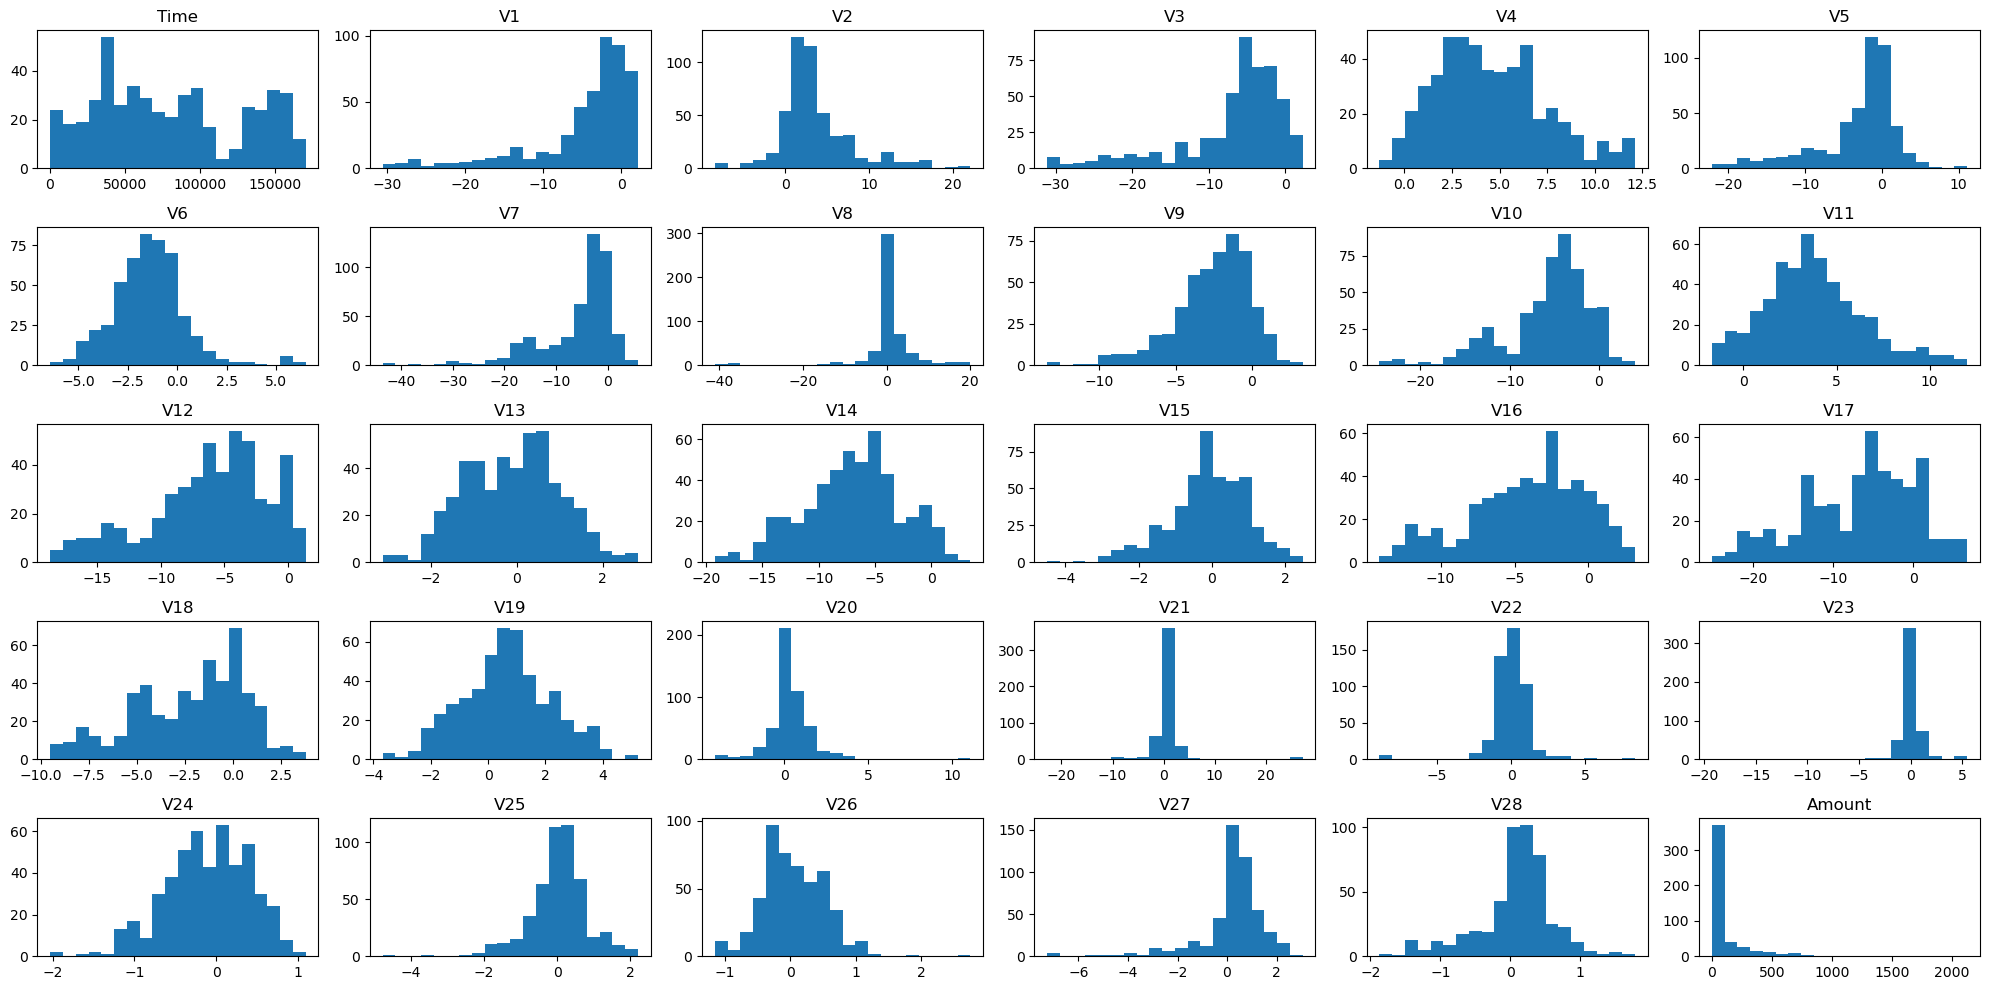

In [12]:
#Dataframe contenant uniquement les observations classées comme fraude
df1 = df.loc[df['Class']==1]
df1 = df1.drop('Class', axis=1)

#Création des histogrammes pour les variables numériques
df1.hist(grid=False, figsize=(20,10), layout=(5,6), bins=20)
plt.tight_layout()
plt.show()

On constate que la distribution de certaines variables diffère selon que les observations sont classés comme frauduleuse ou non. Les variables V2, V4, V10, V11, V12, V14, V16, V17, V18, V19, V27 et V28 semblent plus intéressantes.

On constate que la distribution de certains attributs semble être gaussienne, en forme de cloche, mais beaucoup présentent un skew, un décalage par rapport à une distribution normale.

In [13]:
#Afficahge du skew de chaque variable
df1.skew()

Time      0.251173
V1       -1.797617
V2        1.226561
V3       -1.514985
V4        0.496746
V5       -1.361139
V6        0.867734
V7       -1.827599
V8       -2.830022
V9       -0.975075
V10      -1.152719
V11       0.499090
V12      -0.666830
V13      -0.025996
V14      -0.251554
V15      -0.535066
V16      -0.495263
V17      -0.486095
V18      -0.510684
V19       0.045248
V20       2.162193
V21       2.652616
V22      -1.500123
V23      -5.390189
V24      -0.450894
V25      -0.782811
V26       0.528535
V27      -2.260602
V28      -0.715047
Amount    3.754477
dtype: float64

Plus le skew est important, positiviement ou négativement, plus le décalage est important. Un pré-traitement sera nécessaire pour corriger ces décalages et améliorer la performance des modèles.

Les boîtes à moustaches (boxplot) sont utiles pour détecter la présence d'outliers. La variable Time mesurant le temps écoulé depuis la première transaction, un boxplot sur cette variable n'a pas de sens. La variable Amount n'étant pas normalisée comme les autres variables, son boxplot doit être afficher à part.

Amount    Axes(0.125,0.11;0.775x0.77)
dtype: object

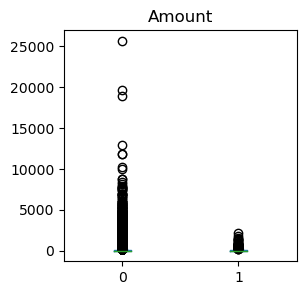

In [14]:
#Affichage du bloxpot de la variable Amount
df.plot.box(column='Amount', by='Class', figsize=(3,3))

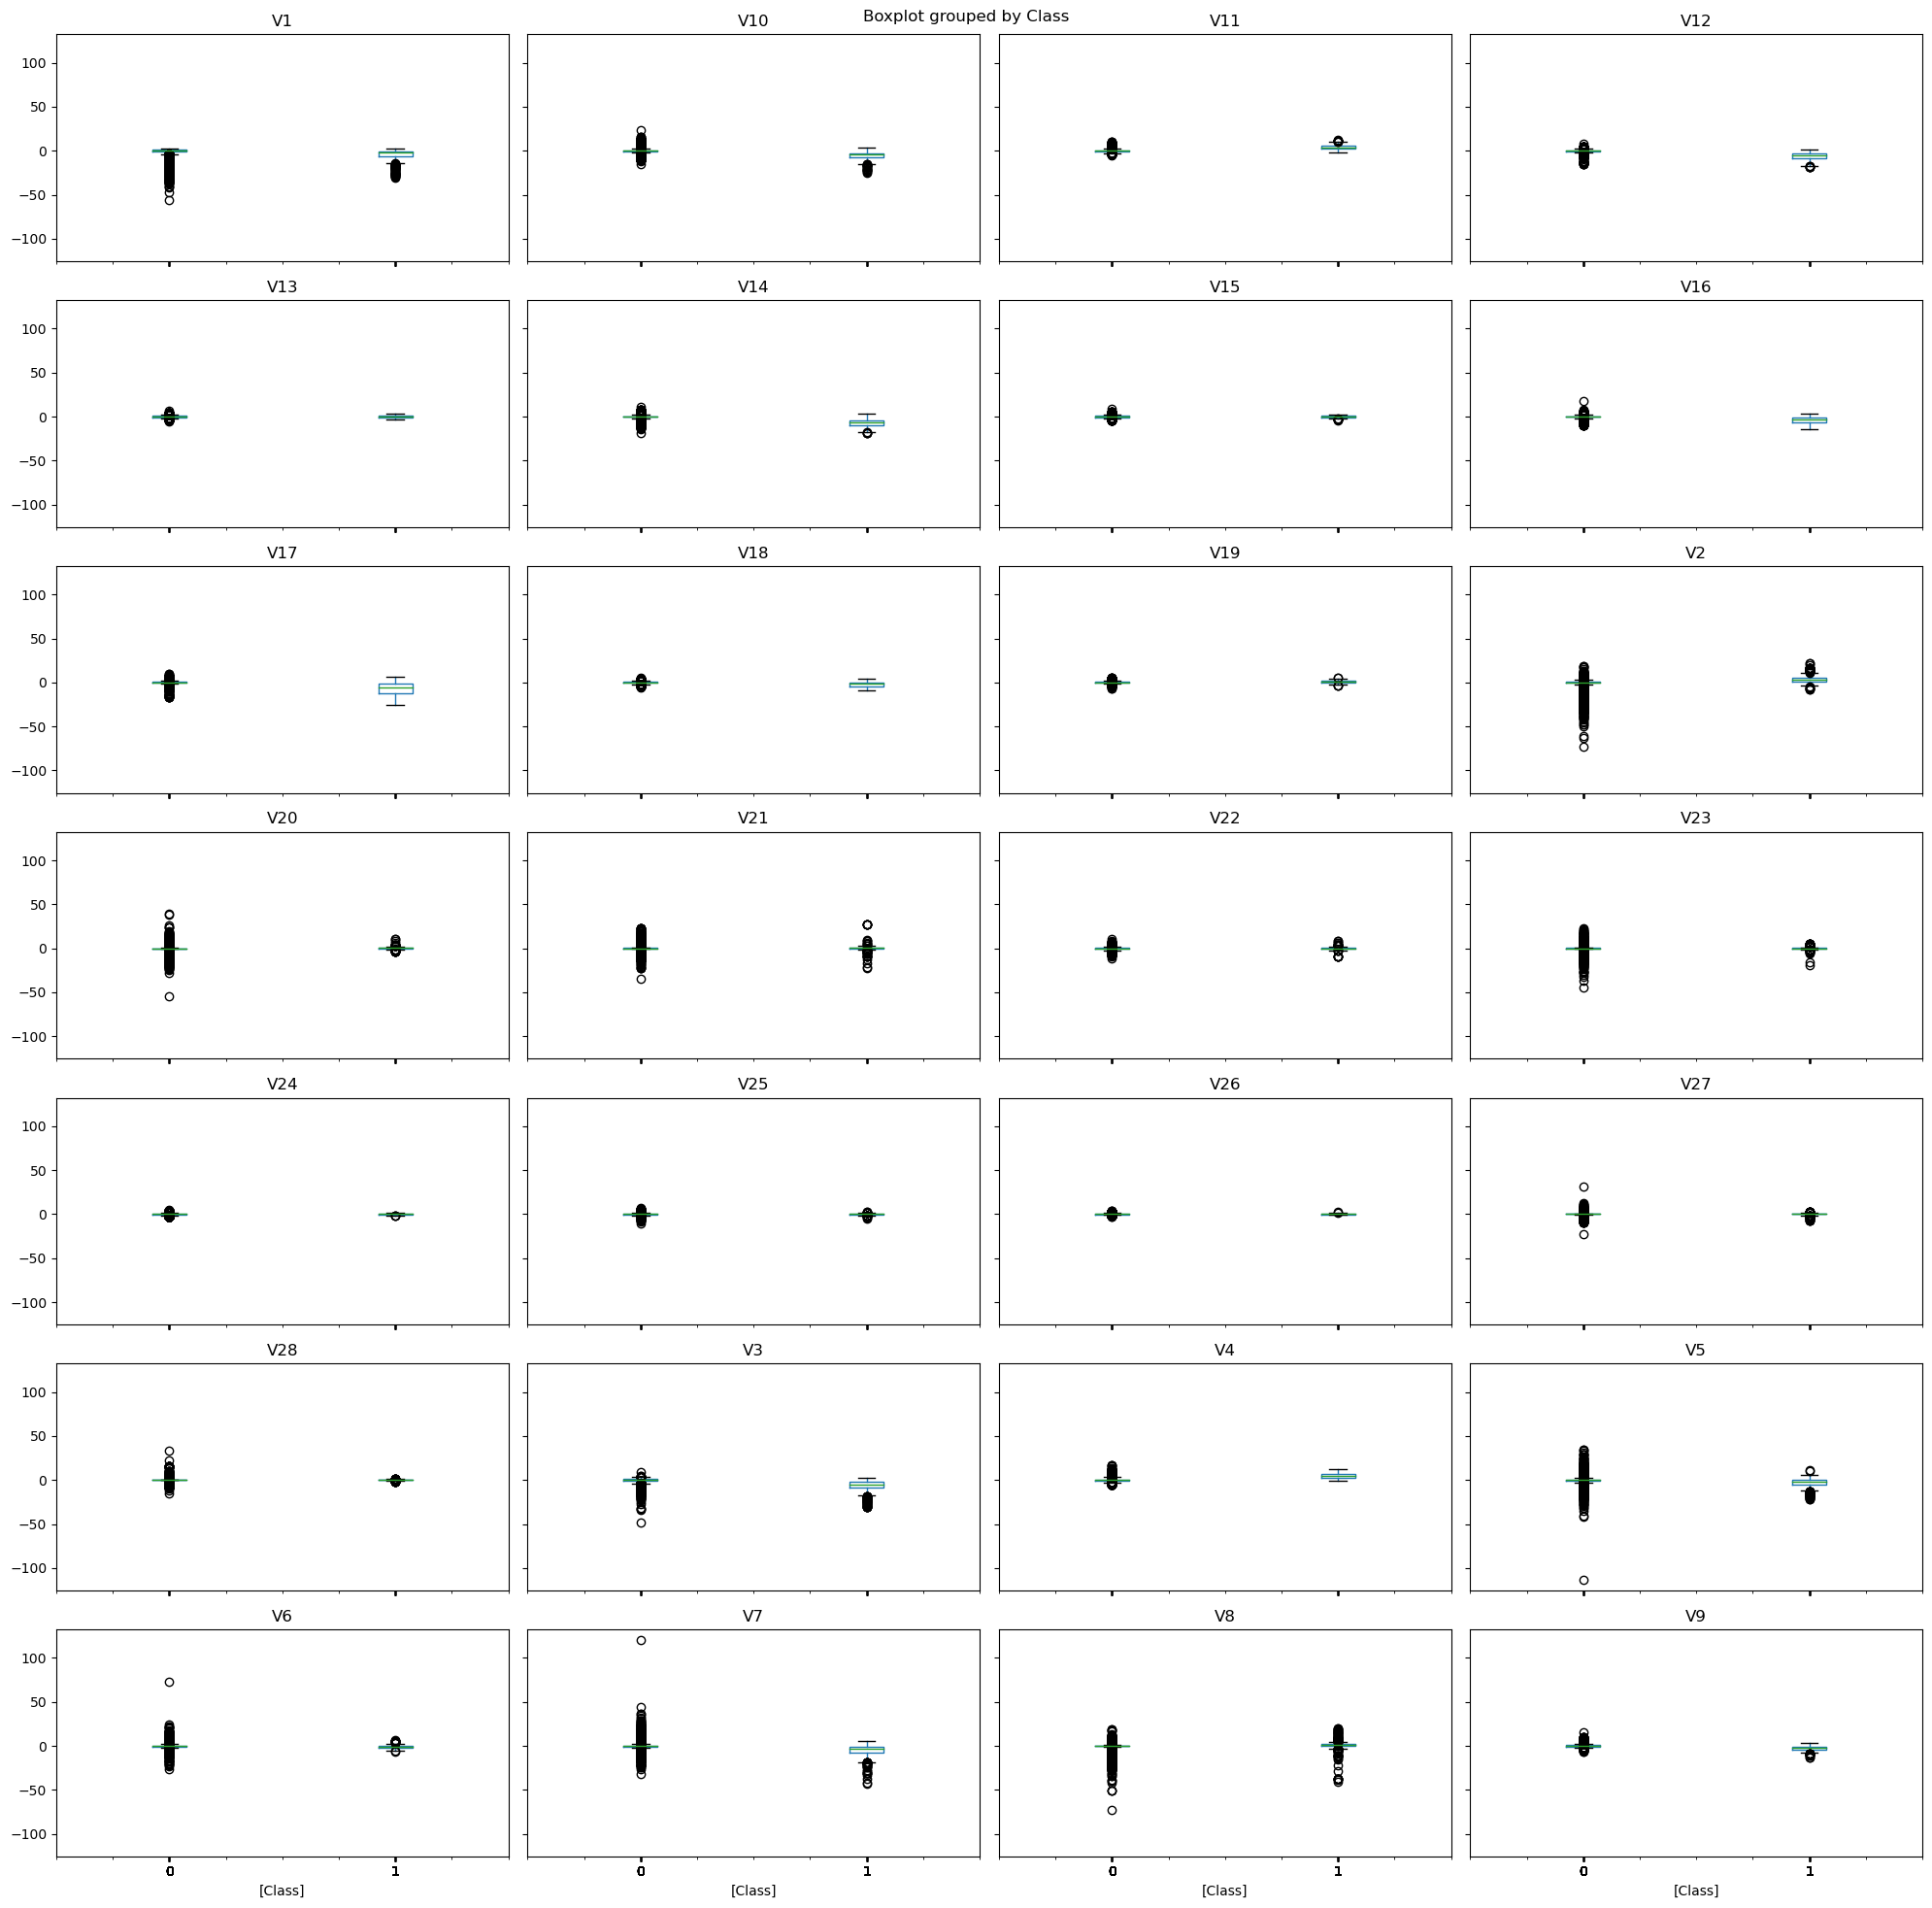

In [15]:
#Affichage du boxplot des autres variables (hormis Time)
df.drop(['Amount', 'Time'], axis=1).boxplot(by='Class', grid=False, figsize=(20,20), layout=(7,4))
plt.tight_layout()
plt.show()

On constate qu'il y a de très nombreux outliers, un pré-traitement sera nécessaire pour éviter qu'ils ne biaisent les algorithmes.

Les variables Amount et Time devront être normalisées.

### Affichez la matrice de corrélation des attributs

La plupart des données présentant un skew, et ayant une tendance plus monotone que strictement linéaire, il est préférable de générer la matrice de corrélation des attributs avec le coefficient de Spearman plutôt qu'avec celui de Pearson.

<Axes: >

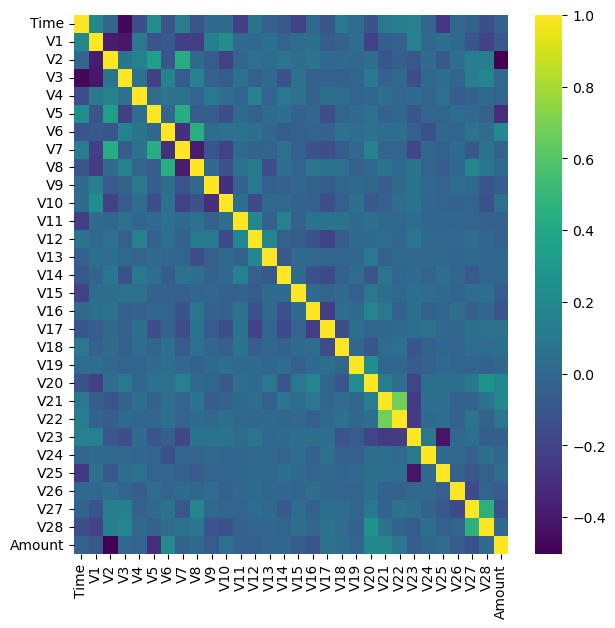

In [16]:
#Séparation du dataset
X = df.drop('Class', axis=1)
y = df['Class']

#Création de la matrice de corrélation avec le coefficient de Spearman
corr_matrix = X.corr('spearman')

f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(corr_matrix, ax=ax, cmap="viridis", linewidths=0)

La matrice donne une indication du degré de corrélation entre les variations de deux variables. Si deux variables évoluent dans le même sens, elles sont corrélées positivement. Si elles évoluent dans des directions opposées (l'une augmente, l'autre diminue), elles sont corrélées négativement.

Il est également utile d'utiliser une matrice de diagramme de dispersion pour repérer les relations structurées entre les variables.

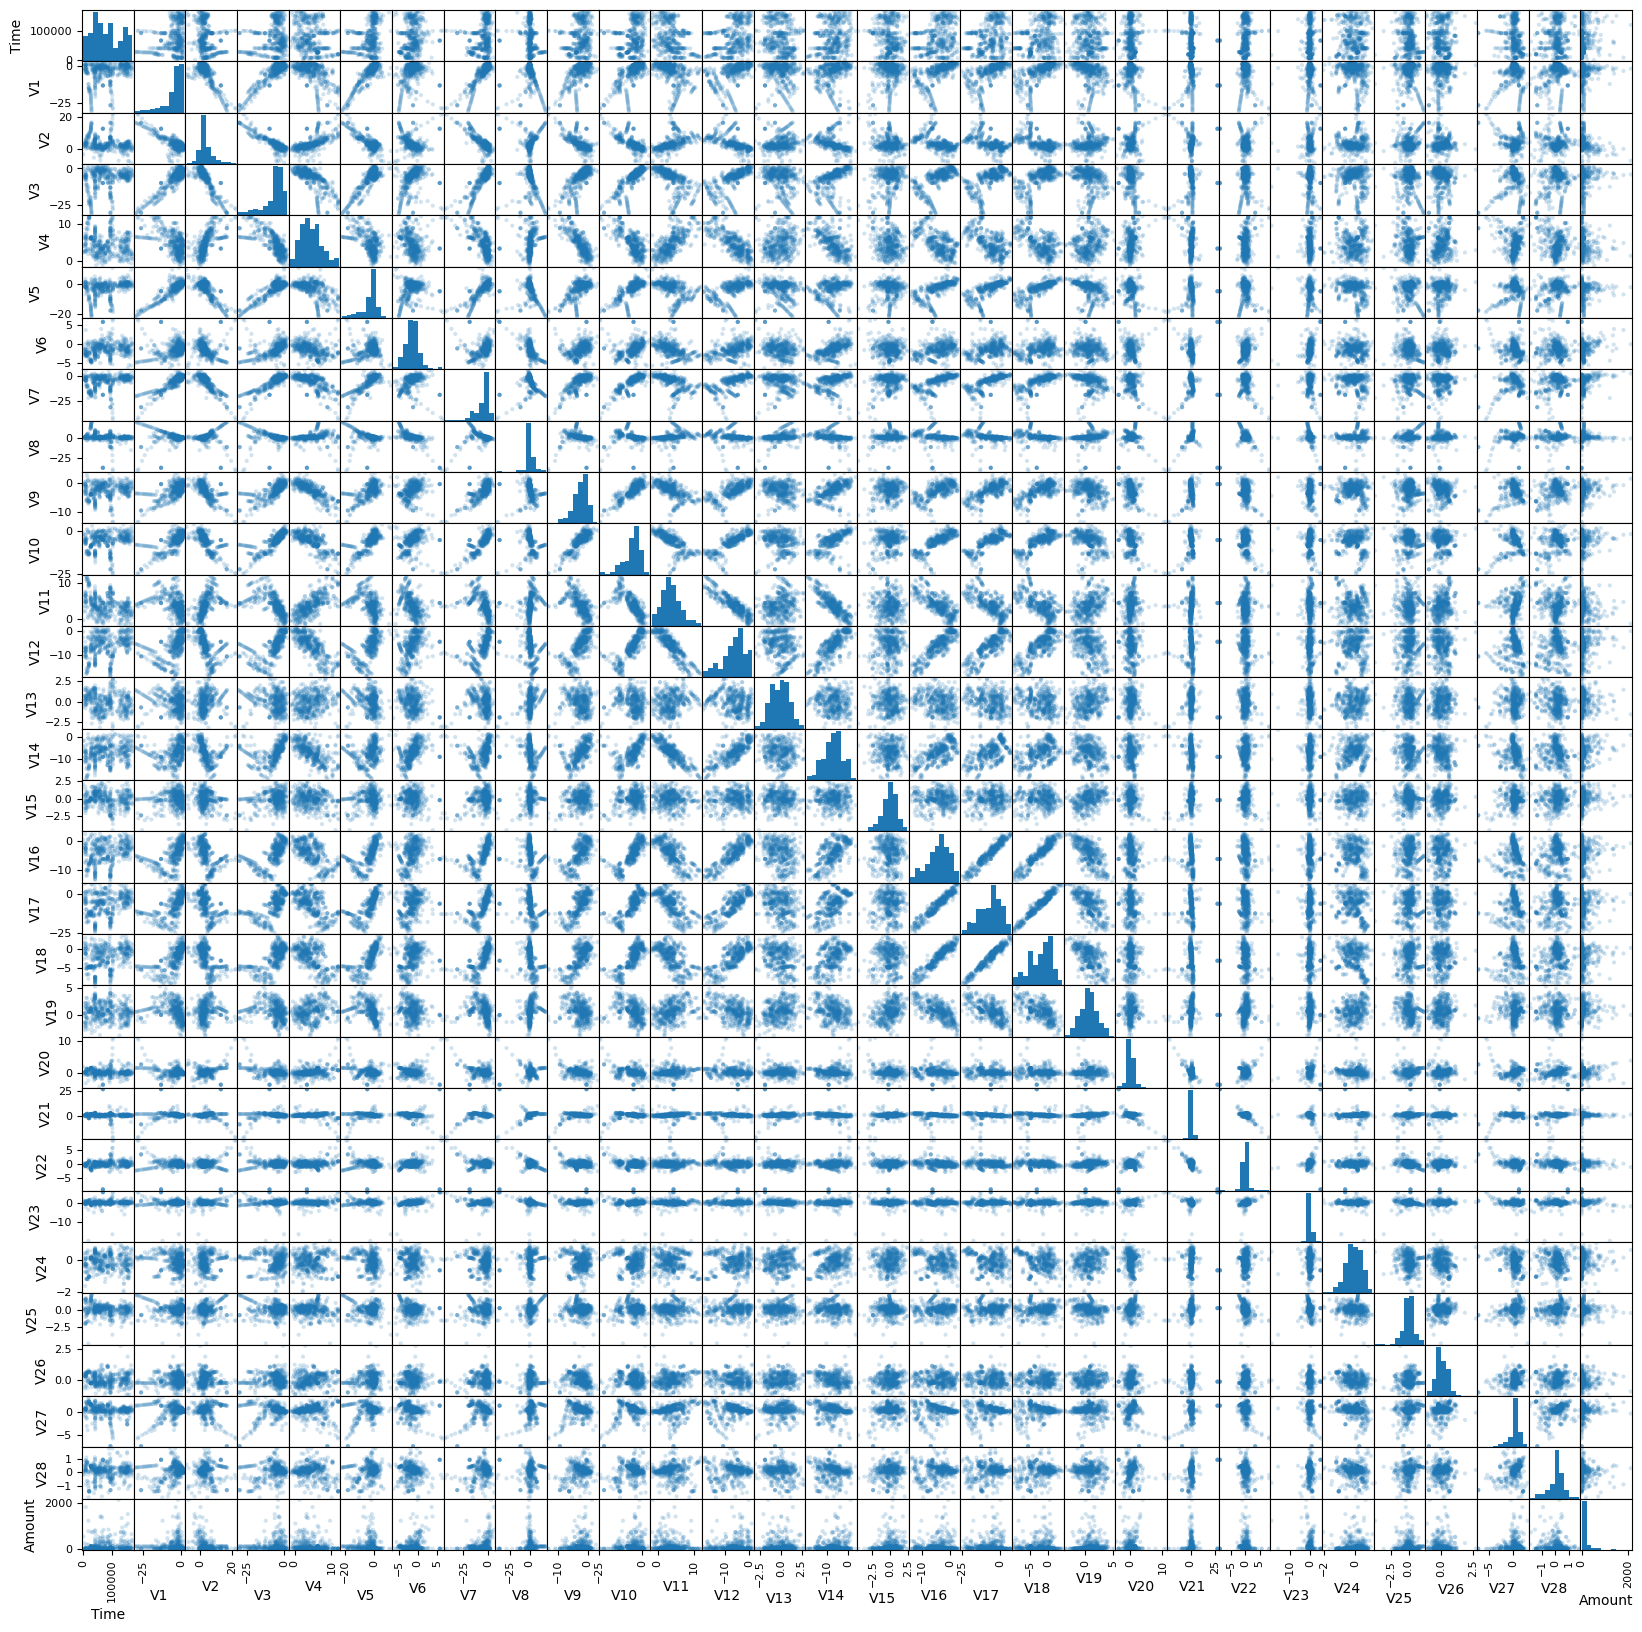

In [26]:
#Création d'une scatter plot matrix
pd.plotting.scatter_matrix(df1, alpha=0.2, figsize=(20,20))
plt.show()

En observant la matrice de corrélation et la matrice de diagramme de dispersion on voit que de nombreuses valeurs semblent avoir une relation strucurée. 

Le coefficient de corrélation bisérial ponctuel mesure la relation entre une variable binaire et une variable continue.

In [18]:
#Calcul du coefficient de corrélation bisérial ponctuel
y = LabelEncoder().fit_transform(y)

for var in list(X):
    print(var, ss.pointbiserialr(y, X[var]))

Time SignificanceResult(statistic=-0.012322570929245751, pvalue=4.818268892543374e-11)
V1 SignificanceResult(statistic=-0.101347298595086, pvalue=0.0)
V2 SignificanceResult(statistic=0.09128865034462011, pvalue=0.0)
V3 SignificanceResult(statistic=-0.19296082706741516, pvalue=0.0)
V4 SignificanceResult(statistic=0.13344748623900599, pvalue=0.0)
V5 SignificanceResult(statistic=-0.09497429899144924, pvalue=0.0)
V6 SignificanceResult(statistic=-0.04364316069996431, pvalue=4.21311134585505e-120)
V7 SignificanceResult(statistic=-0.18725659151429977, pvalue=0.0)
V8 SignificanceResult(statistic=0.019875123914794558, pvalue=2.740673101601223e-26)
V9 SignificanceResult(statistic=-0.09773268607407984, pvalue=0.0)
V10 SignificanceResult(statistic=-0.2168829436410296, pvalue=0.0)
V11 SignificanceResult(statistic=0.1548756447439489, pvalue=0.0)
V12 SignificanceResult(statistic=-0.2605929248772196, pvalue=0.0)
V13 SignificanceResult(statistic=-0.004569778799461301, pvalue=0.014737338962980347)
V14 S

Les p-values indiquent que les variables continues et la classe ne sont pas indépendantes. Les variables V3, V4, V7, V10, V11, V12, V14, V16 et V17 sont les plus corrélées avec la classe.

V4 et V11 sont corrélées positivement: plus leur valeur est haute, plus la transaction est susceptible d'être classées comme frauduleuse.

V3, V7, V10, V12 et V14, V16, V17 sont corrélées négativement: plus leur valeur est basse, plus la transaction est susceptible d'être classées comme frauduleuse.

### Que pouvez-vous déjà conclure? Y-a-t’il des attributs qui semblent être fortement liés au comportement de churn?

Si parmi les variables explicatives qui semblent liées on élimine celles qui sont le moins corrélées avec la classe à prédire, il reste : V3, V10, V11, V17.

On peut confronter nos déductions avec une analyse de variance (ANOVA) et d'information mutuelle (Mutual Information).

In [19]:
#Sélection des 4 variables les plus pertinentes avec ANOVA 
fs = SelectKBest(score_func=f_classif, k=4)
X_anova = fs.fit_transform(X, y)
X.columns[fs.get_support()]

Index(['V10', 'V12', 'V14', 'V17'], dtype='object')

In [20]:
#Sélection des 4 variables les plus pertinentes avec Mutual Information
fs = SelectKBest(score_func=mutual_info_classif, k=4)
X_mi = fs.fit_transform(X, y)
X.columns[fs.get_support()]

Index(['V10', 'V12', 'V14', 'V17'], dtype='object')

On retrouve V10, et V17. Nous avions éliminé V12 et V14 car elles sont fortement corrélées à V10.

Notre expertise ne nous permet pas d'appuyer cette analyse exploratoire et de discriminer certaines variables. Nous allons donc poursuivre avec toutes les variables.

In [ ]:
#Enregistrement des données 
df.to_csv('data/creditcard_v2.csv', index=False)

# Dataset : Bank marketing

### Quelles sont les dimensions du jeu de données, existe-t’il des valeurs manquantes ou des attributs constants?

In [220]:
#Chargement des données 
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [221]:
#Affichage des premières lignes
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [222]:
#Affichage du nombre de dimensions
print('Le dataset est de dimension', df.columns.size)

Le dataset est de dimension 21


In [223]:
#Affichage du nombre de valeurs NA
print('Le dataset contient', df.isna().sum().sum(), 'valeurs NA')

Le dataset contient 0 valeurs NA


In [224]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

Il n'y a pas d'attribut constant puisque chacun a au moins deux valeurs différentes.

### Affichez à l’aide d'un graphe adapté la proportion d’individus qui ont churné

In [225]:
#Distribution des classes
class_counts = df.groupby('y').size()
class_counts

y
no     36548
yes     4640
dtype: int64

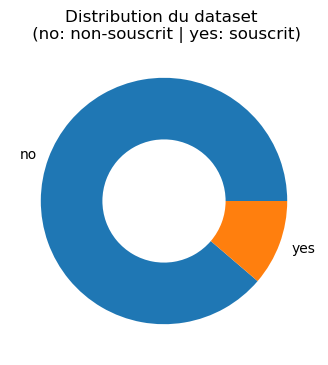

In [226]:
#Comparaison des populations des deux classes à l'aide d'un graphique
fig, ax = plt.subplots(figsize=(4, 4))
#Graphique
ax.pie(x=df['y'].value_counts(), 
       labels=df['y'].value_counts().index, 
       wedgeprops={"width": 0.5})
#Titre
ax.set_title('Distribution du dataset \n (no: non-souscrit | yes: souscrit)')
#Affichage
plt.show()

In [227]:
#Affichage de la proportion des observations correspondant à une souscription
print('Les souscrits représentent seulement', round(df['y'].value_counts()[1]/len(df) * 100,2), '% du dataset')

Les souscrits représentent seulement 11.27 % du dataset


### Pour chaque variable catégorielle, affichez à l’aide un graphe adapté la proportion de churn vs. non churn

Les distributions étant très déséquilibrées, il faut créer des graphiques différents pour chaque classe. Autrement les valeurs de la classe minoritaire ne seront pas visibles.

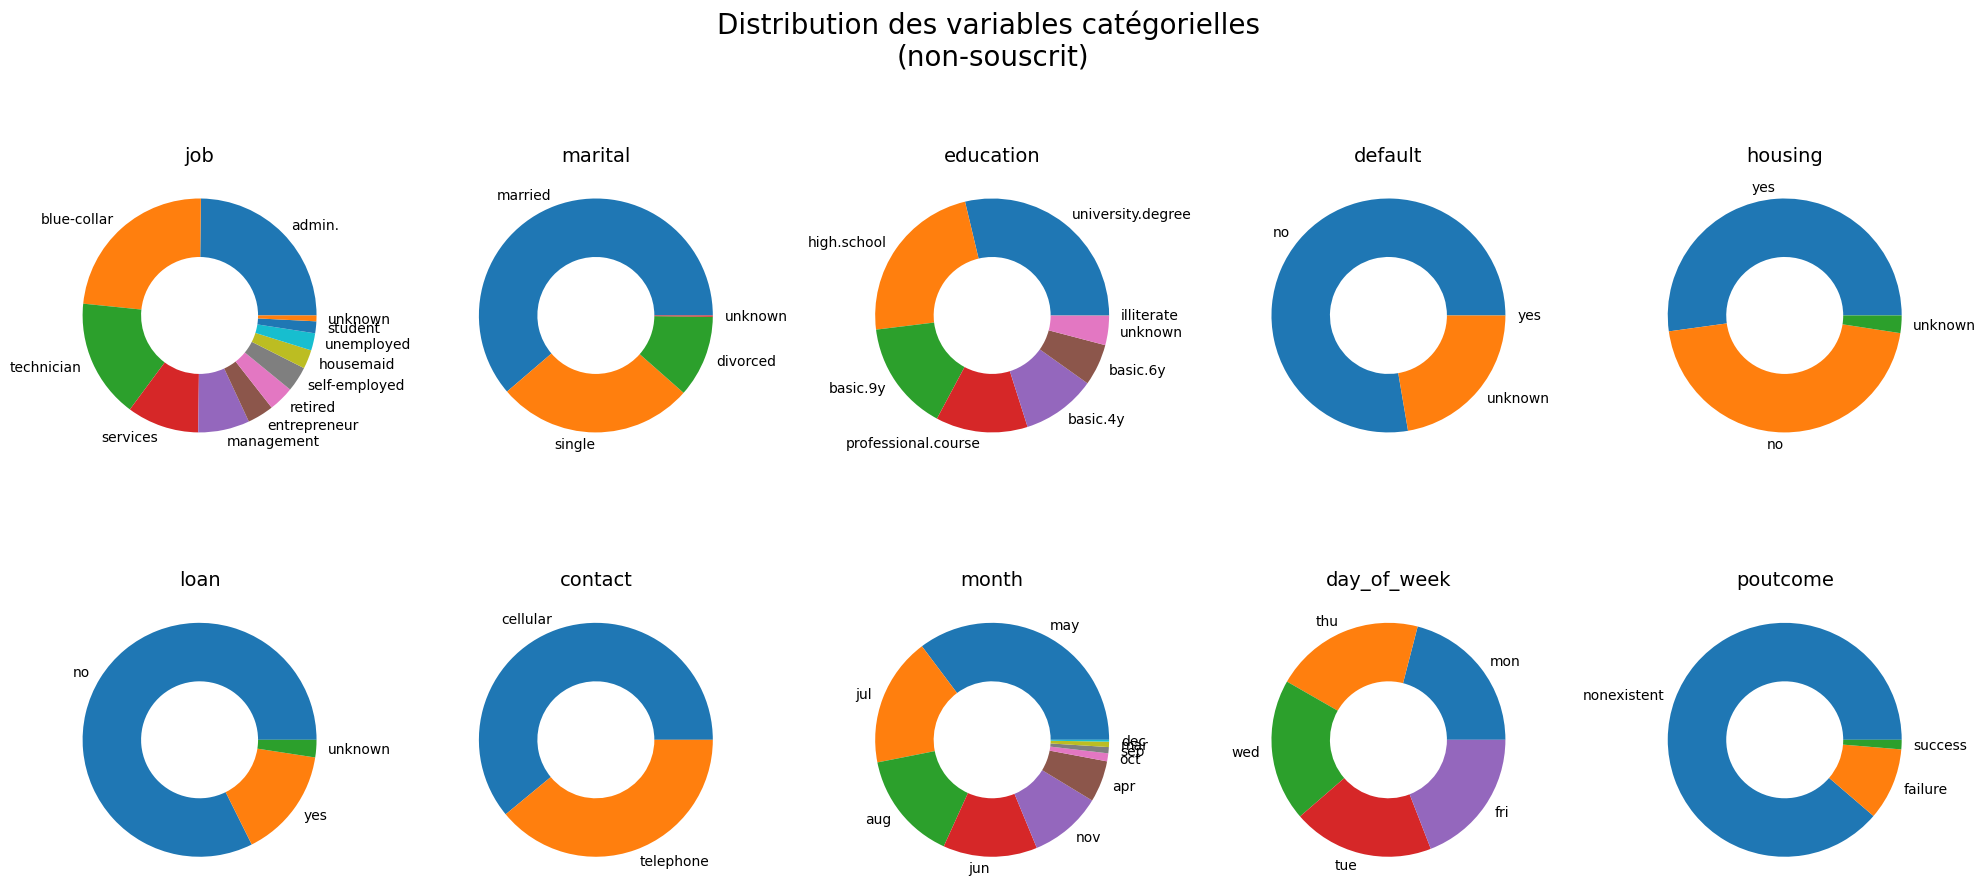

In [228]:
#Dataframe contenant uniquement les observations classées comme non-souscrit
df0 = df.loc[df['y']=='no']
df0 = df0.drop('y', axis=1)

#Récupération du nom des variables qualitatives nominales
var_nom = list(df0.select_dtypes(['object']).columns)

#Création d'un pie chart pour chaque variable
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axe = axs.ravel()
for i, cat in enumerate(df0[var_nom]):
    ax = axe[i]
    ax.pie(x=df0[cat].value_counts(), 
           labels=df0[cat].value_counts().index,
           wedgeprops={"width": 0.5})
    ax.set_title(cat, fontsize=14)
fig.suptitle('Distribution des variables catégorielles \n(non-souscrit)', fontsize=20)
#Affichage
fig.tight_layout()
plt.show()

In [ ]:
#Dataframe contenant uniquement les observations classées comme souscrit
df1 = df.loc[df['y']=='yes']
df1 = df1.drop('y', axis=1)

#Création d'un pie chart pour chaque variable
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axe = axs.ravel()
for i, cat in enumerate(df1[var_nom]):
    ax = axe[i]
    ax.pie(x=df1[cat].value_counts(), 
           labels=df1[cat].value_counts().index,
           wedgeprops={"width": 0.5})
    ax.set_title(cat, fontsize=14)
fig.suptitle('Distribution des variables catégorielles \n(souscrit)', fontsize=20)
#Affichage
fig.tight_layout()
plt.show()

On constate que la distribution des variables job, default, contact, poutcome varie selon que les observations sont classées comme souscrit ou non-souscrit.

### Pour chaque variable numérique, affichez séparemment à l’aide un graphe adapté (eg. histogramme) les valeurs pour les populations churn & non churn

Les distributions étant très déséquilibrées, il faut créer des graphiques différents pour chaque classe. Autrement les valeurs de la classe minoritaire ne seront pas visibles.

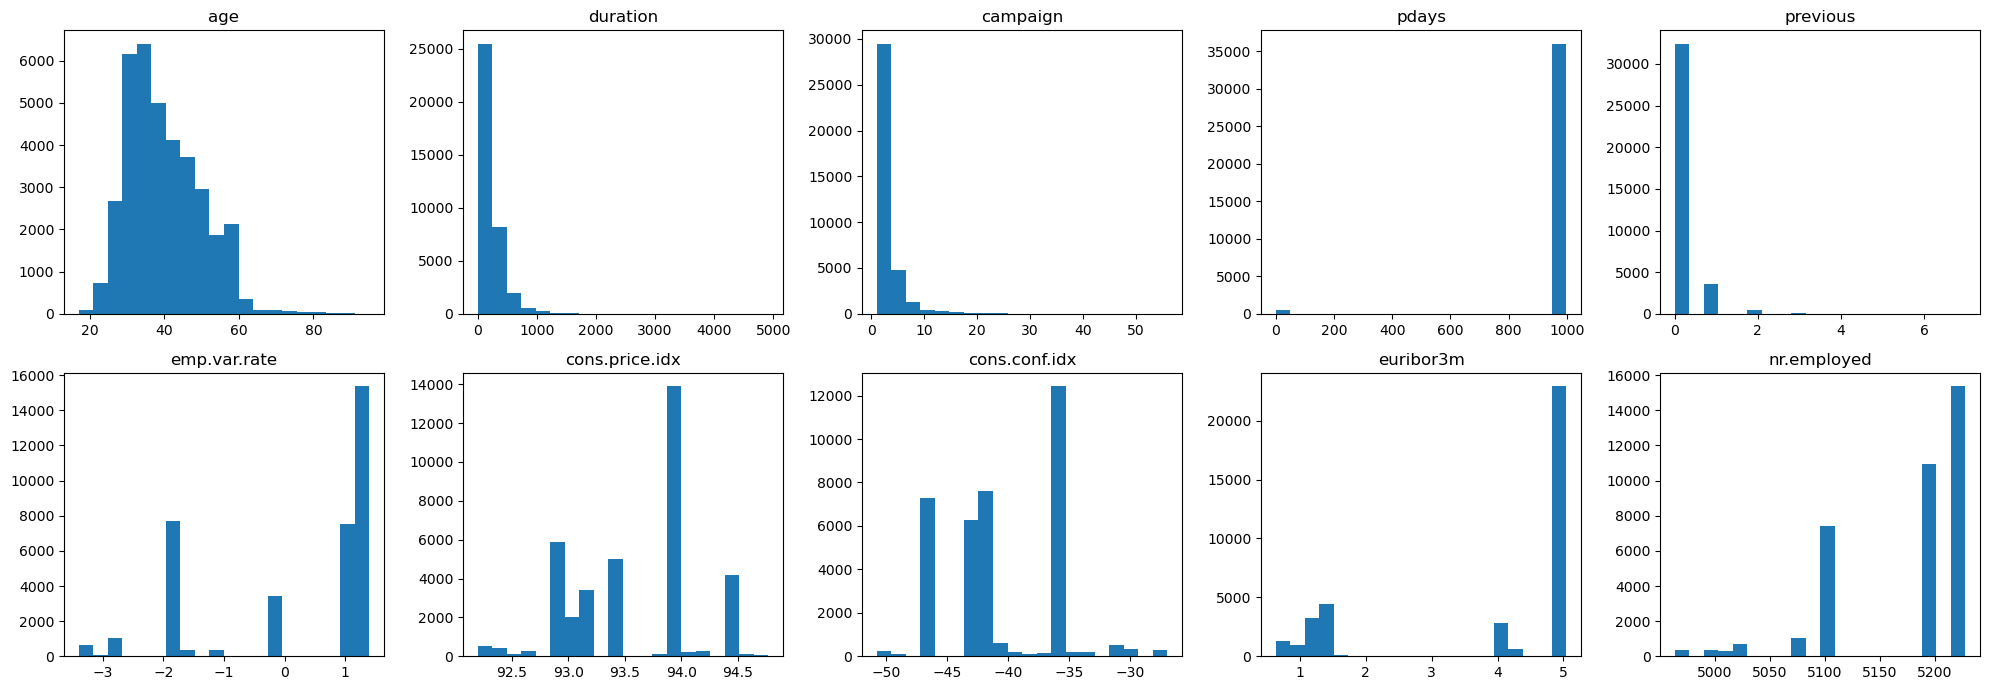

In [229]:
#Dataframe contenant uniquement les observations classées comme non-souscrit
df0 = df.loc[df['y']=='no']
df0 = df0.drop('y', axis=1)

#Création des histogrammes pour les variables quantitatives
df0.hist(grid=False, figsize=(20,7), layout=(2,5), bins=20)
plt.tight_layout()
plt.show()

In [ ]:
#Dataframe contenant uniquement les observations classées comme souscrit
df1 = df.loc[df['y']=='yes']
df1 = df1.drop('y', axis=1)

#Création des histogrammes pour les variables quantitatives
df1.hist(grid=False, figsize=(20,7), layout=(2,5), bins=20)
plt.tight_layout()
plt.show()

On constate que la distribution de certaines variables diffère selon que les observations sont classés comme souscrit ou non. Les variables emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m et nr.employed semblent plus intéressantes.

Seule la variable age a une distribution gaussienne, en forme de cloche.

Les boîtes à moustaches (boxplot) sont utiles pour détecter la présence d'outliers. La variable duration, pdays et nr.employed n'étant pas du tout à la même échelle que les autres, leur boxplot doit être affiché à part.

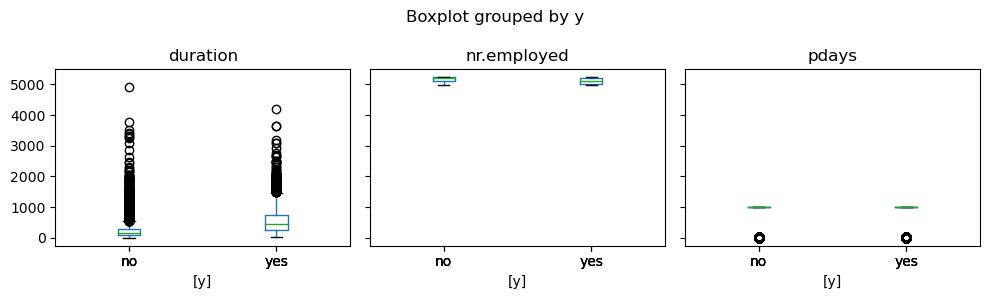

In [230]:
#Liste des variables quantitatives
var_quant = list(df.select_dtypes(exclude = ['object']).columns)

#Affichage du bloxpot des variables duration, pdays et nr.employed
df_box = df[['duration', 'pdays', 'nr.employed', 'y']]

df_box.boxplot(by='y', grid=False, figsize=(10,3), layout=(1,3))
plt.tight_layout()
plt.show()

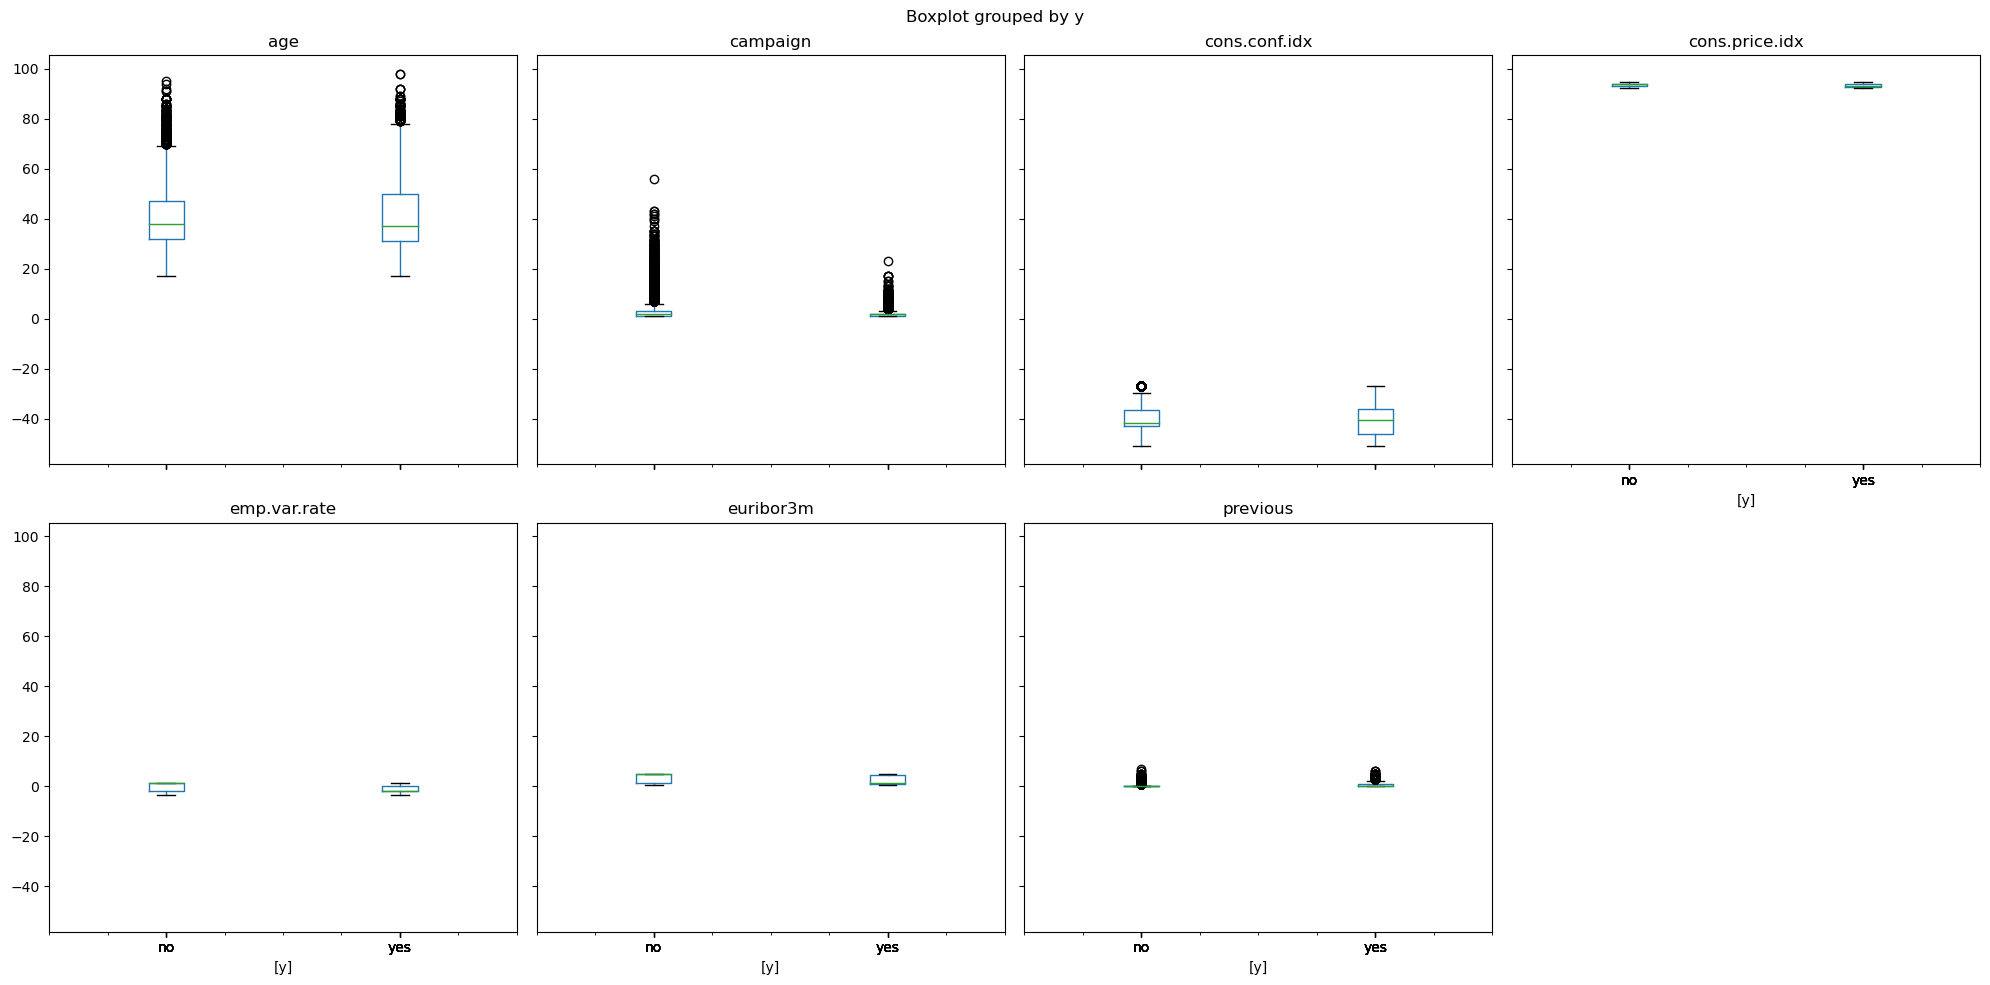

In [231]:
#Affichage du bloxpot des autres variables
df_box = df[var_quant + ['y']].drop(['duration', 'pdays', 'nr.employed'], axis=1)

df_box.boxplot(by='y', grid=False, figsize=(20,10), layout=(2,4))
plt.tight_layout()
plt.show()

On constate que certaines variables (age, duration, pdays) ont de nombreux outliers, un pré-traitement sera nécessaire pour éviter qu'ils ne biaisent les algorithmes. Une solution est de transformer ces variables quantitatives en variables catégorielles à partir des quartiles. Les autres variables devront être redimensionnées.

In [232]:
#Regroupement des âges en 4 catégories (en fonction des quartiles)
df.loc[(df['age'] <= 32), 'age'] = 0
df.loc[(df['age'] > 32) & (df['age'] <= 38), 'age'] = 1
df.loc[(df['age'] > 38) & (df['age'] <= 47), 'age'] = 2
df.loc[(df['age'] > 47), 'age'] = 3

#Regroupement des durées d'appel en 4 catégories (en fonction des quartiles)
df.loc[(df['duration'] <= 102), 'duration'] = 0
df.loc[(df['duration'] > 102) & (df['duration'] <= 180), 'duration'] = 1
df.loc[(df['duration'] > 180) & (df['duration'] <= 321), 'duration'] = 2
df.loc[(df['duration'] > 321), 'duration'] = 3

#Regroupement de la variable pdays en 4 catégories 
df.loc[(df['pdays'] == 999), 'pdays'] = 0
df.loc[(df['pdays'] >= 0) & (df['pdays'] <= 15), 'pdays'] = 1
df.loc[(df['pdays'] >= 15) & (df['pdays'] <= 30), 'pdays'] = 2
df.loc[(df['pdays'] >= 30) & (df['pdays'] < 999), 'pdays'] = 3

#Conversion de ces variables en type object
df[['age', 'duration', 'pdays']] = df[['age', 'duration', 'pdays']].astype('object')

#Modification des listes des variables quantitatives et qualitatives nominales
var_nom += ['age', 'duration', 'pdays']
var_quant = list(df.select_dtypes(exclude = ['object']).columns)

### Affichez la matrice de corrélation des attributs

Seules les données quantitatives peuvent être utilisées dans une matrice de corrélation. Inclure les variables catégorielles encodées numériquement serait erroné et conduirait à de fausses conclusions.

La plupart des données n'ayant pas une distribution gaussienne et présentant une tendance monotone plutôt que linéaire, il est préférable de générer la matrice de corrélation des attributs avec le coefficient de Spearman plutôt qu'avec celui de Pearson.

<Axes: >

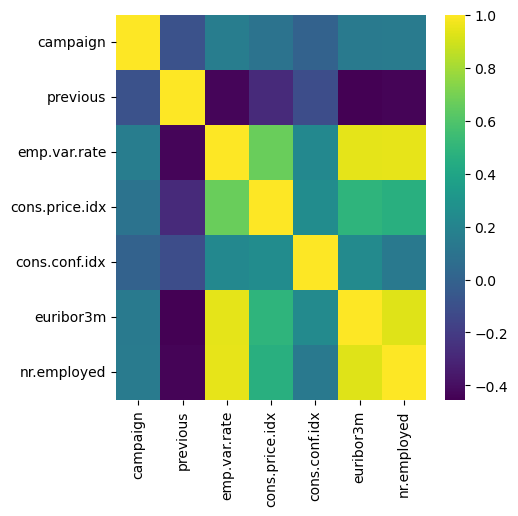

In [233]:
#Séparation du dataset
X = df.drop('y', axis=1)
y = df['y']

#Création de la matrice de corrélation avec le coefficient de Spearman
corr_matrix = X[var_quant].corr('spearman')

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(corr_matrix, ax=ax, cmap="viridis", linewidths=0)

La matrice donne une indication du degré de corrélation entre les variations de deux variables. Si deux variables évoluent dans le même sens, elles sont corrélées positivement. Si elles évoluent dans des directions opposées (l'une augmente, l'autre diminue), elles sont corrélées négativement.

Il est également utile d'utiliser une matrice de diagramme de dispersion pour repérer les relations structurées entre les variables.

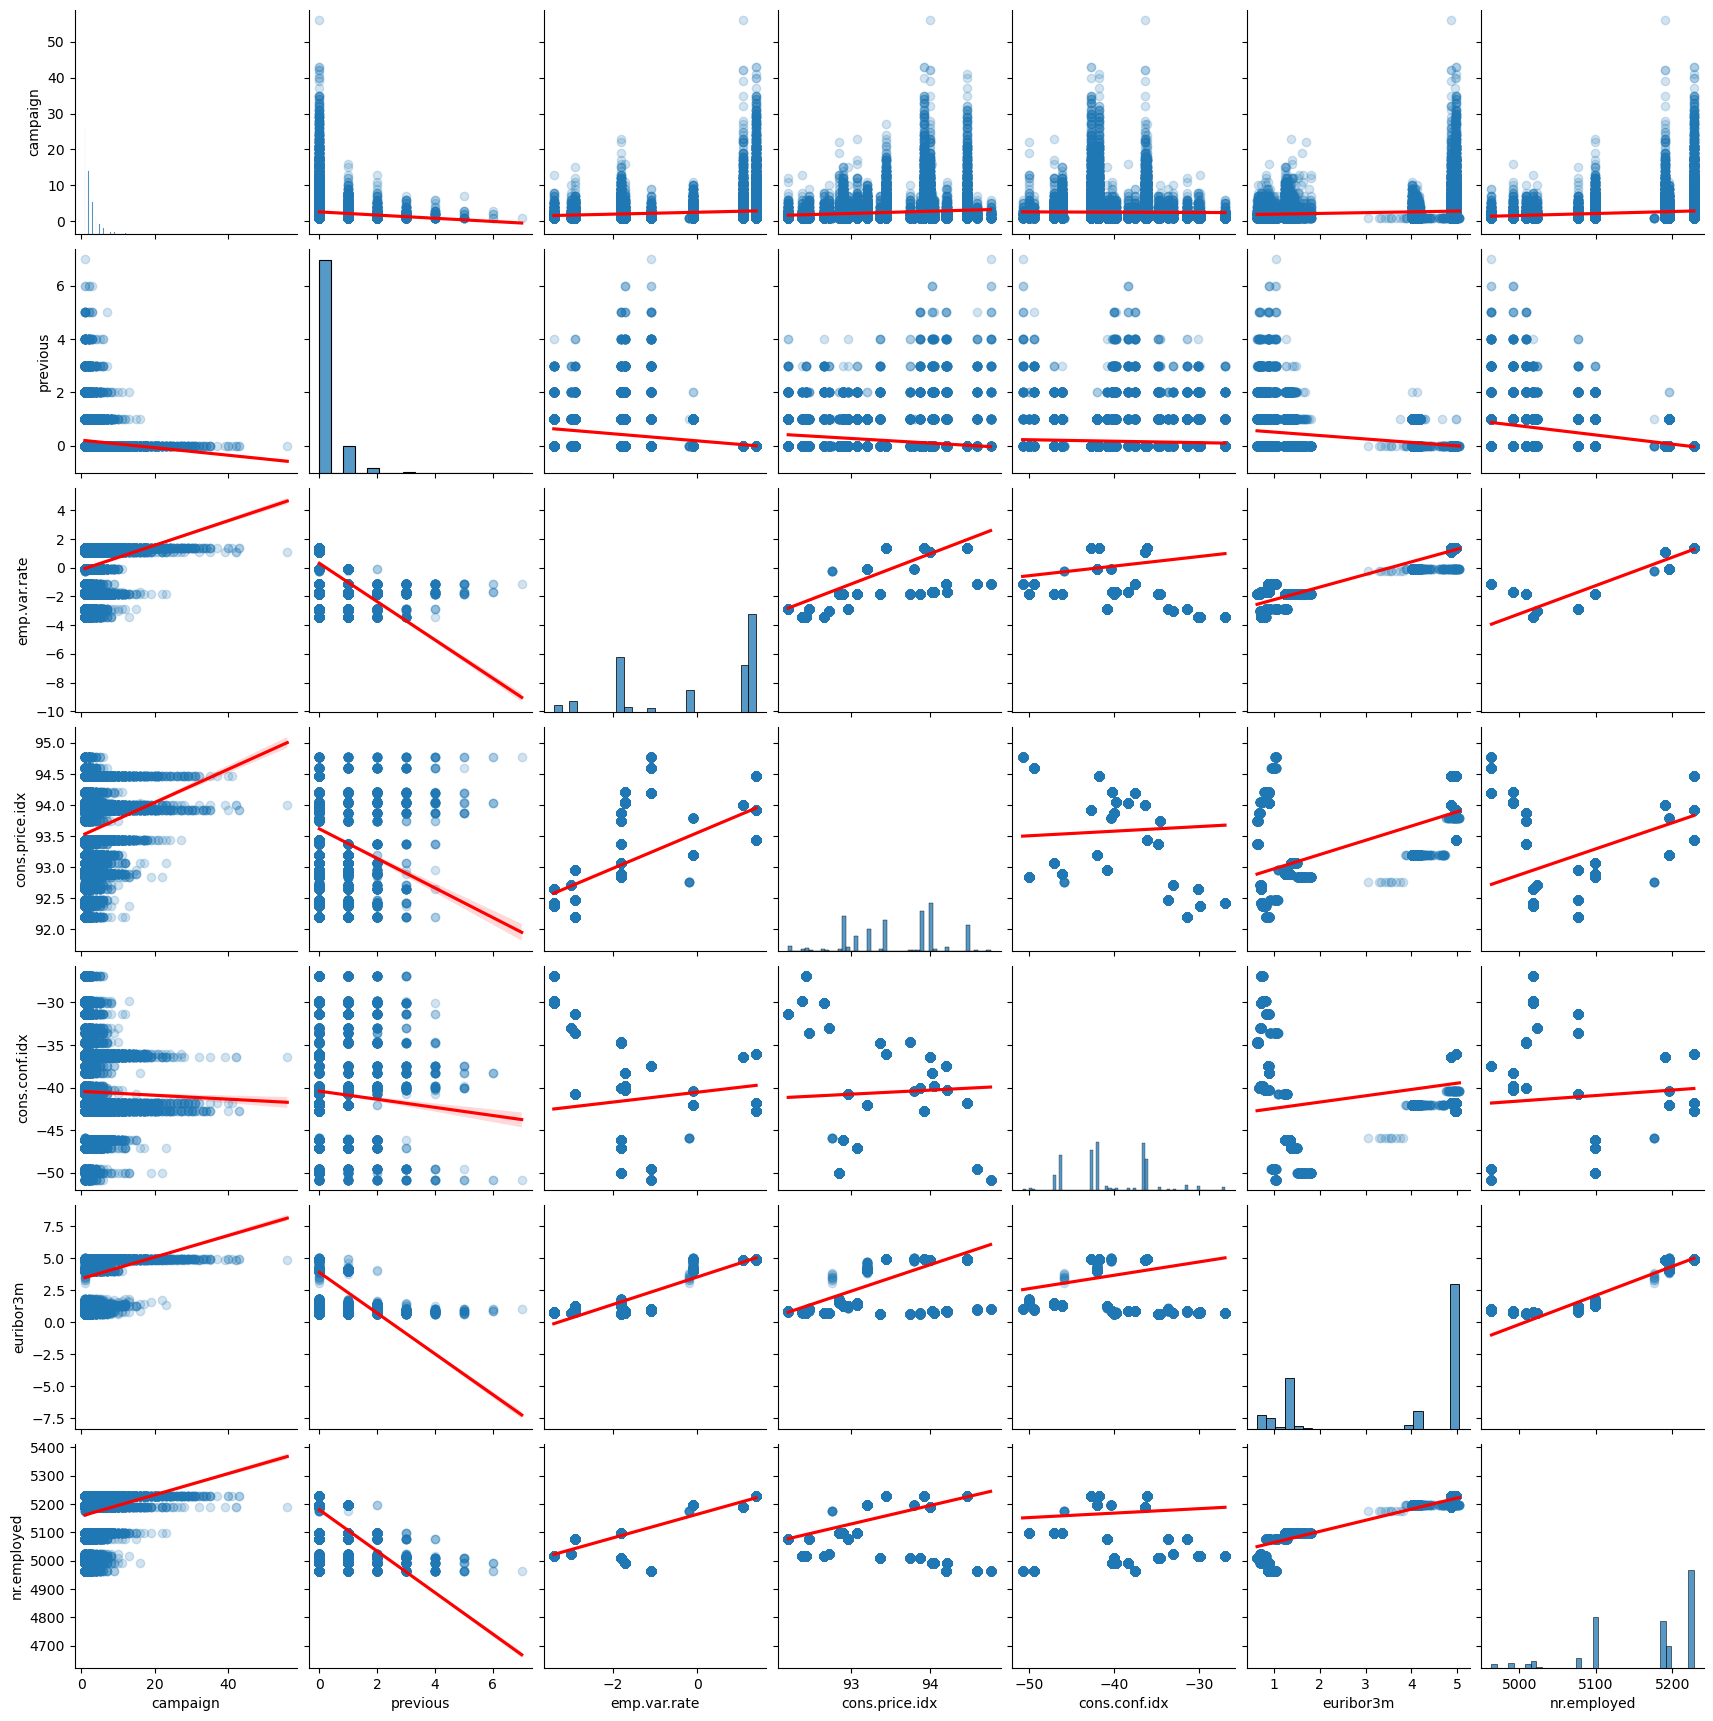

In [234]:
#Création d'une matrice de dispersion
sns.pairplot(X[var_quant], kind="reg", 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2}})

On constate que certaines variables sont corrélées. Il est intéressant de noter que les variables sur les campagnes précédentes (campaign et previous) sont liées avec celles sur le contexte économique (emp.var.rate, cons.price.idx, euribor3m et nr.employed). L'entreprise semble adapter sa stratégie marketing à la conjoncture et contacte moins lorsque le chômage et l'inflation sont élevés.

Par ailleurs, si des variables contiennent en partie la même information l'algorithme risque d'être biaisé. Il ne faudrait conserver qu'une seule variable comme entre emp.var.rate et nr.employed.

Le coefficient de corrélation bisérial ponctuel mesure la relation entre une variable binaire et une variable continue.

In [235]:
#Calcul du coefficient de corrélation bisérial ponctuel
y = LabelEncoder().fit_transform(y)

for var in var_quant:
    print(var, ss.pointbiserialr(y, X[var]))

campaign SignificanceResult(statistic=-0.06635741475467088, pvalue=2.0077799907200388e-41)
previous SignificanceResult(statistic=0.23018100321659116, pvalue=0.0)
emp.var.rate SignificanceResult(statistic=-0.2983344261593779, pvalue=0.0)
cons.price.idx SignificanceResult(statistic=-0.1362112128192492, pvalue=9.318964779908526e-170)
cons.conf.idx SignificanceResult(statistic=0.054877946053195875, pvalue=7.536664996977963e-29)
euribor3m SignificanceResult(statistic=-0.30777140394072083, pvalue=0.0)
nr.employed SignificanceResult(statistic=-0.35467829592143674, pvalue=0.0)


Les p-values indiquent que les variables quantitatives et la classe ne sont pas indépendantes. Les coefficients de corrélation indiquent que certaines variables sont fortement corrélées avec la classe. En recoupant avec les observations des matrice de corrélation et de dispersion nr.employed, euribor3m, previous et cons.price.idx semblent être les meilleures candidates.

Pour les variables catégorielles d'autres mesures doivent être utilisées. Le V de Cramer indique le degré d'association entre deux variables nominales.

In [236]:
#Conversion des valeurs des variables qualitatives codées en texte en entier
encoder = LabelEncoder()
for var in var_nom:
    X[var] = encoder.fit_transform(X[var])

#Calcul des V de Cramer
cols = var_nom + ['y']
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

#Création d'une matrice
pd.DataFrame(corrM, index=cols, columns=cols)

job   marital  education   default   housing      loan  \
job          0.000000  0.183590   0.359526  0.152101  0.010630  0.010218   
marital      0.183590  0.000000   0.116240  0.095434  0.009170  0.000000   
education    0.359526  0.116240   0.000000  0.170355  0.013316  0.000000   
default      0.152101  0.095434   0.170355  0.000000  0.010573  0.001567   
housing      0.010630  0.009170   0.013316  0.010573  0.000000  0.707852   
loan         0.010218  0.000000   0.000000  0.001567  0.707852  0.000000   
contact      0.127856  0.071993   0.123302  0.135554  0.084603  0.024206   
month        0.109835  0.050174   0.094718  0.111926  0.054243  0.019830   
day_of_week  0.016458  0.010888   0.019725  0.011314  0.014635  0.006104   
poutcome     0.099560  0.036630   0.042282  0.076628  0.016958  0.000000   
age          0.253796  0.255678   0.150412  0.138789  0.005067  0.000000   
duration     0.023662  0.003250   0.012978  0.011172  0.008523  0.009511   
pdays        0.036935  0.021588   0.022720  0.013969  0.002140  0.007096   
y            0.151893  0.053900   0.067220  0.099111  0.009458  0.000000   

              contact     month  day_of_week  poutcome       age  duration  \
job          0.127856  0.109835     0.016458  0.099560  0.253796  0.023662   
marital      0.071993  0.050174     0.010888  0.036630  0.255678  0.003250   
education    0.123302  0.094718     0.019725  0.042282  0.150412  0.012978   
default      0.135554  0.111926     0.011314  0.076628  0.138789  0.011172   
housing      0.084603  0.054243     0.014635  0.016958  0.005067  0.008523   
loan         0.024206  0.019830     0.006104  0.000000  0.000000  0.009511   
contact      0.000000  0.609087     0.054906  0.242419  0.074556  0.033597   
month        0.609087  0.000000     0.066569  0.242400  0.082714  0.067032   
day_of_week  0.054906  0.066569     0.000000  0.014579  0.028262  0.030369   
poutcome     0.242419  0.242400     0.014579  0.000000  0.047234  0.059898   
age          0.074556  0.082714     0.028262  0.047234  0.000000  0.000000   
duration     0.033597  0.067032     0.030369  0.059898  0.000000  0.000000   
pdays        0.016520  0.079972     0.000000  0.096326  0.011156  0.011311   
y            0.144611  0.274000     0.023188  0.320416  0.076577  0.345023   

                pdays         y  
job          0.036935  0.151893  
marital      0.021588  0.053900  
education    0.022720  0.067220  
default      0.013969  0.099111  
housing      0.002140  0.009458  
loan         0.007096  0.000000  
contact      0.016520  0.144611  
month        0.079972  0.274000  
day_of_week  0.000000  0.023188  
poutcome     0.096326  0.320416  
age          0.011156  0.076577  
duration     0.011311  0.345023  
pdays        0.000000  0.038178  
y            0.038178  0.000000

Cette matrice indique les variables qui sont corrélées entre elles et qui ont donc potentiellement un lien. C'est le cas des variables Age, Marital, Education et Job. Ces variables sont redondantes.

Les variables duration, poutcome, month et contact sont les plus corrélées à la classe à prédire et sont peu corrélées entre elles. Elles semblent être de bonnes variables candidates pour nos modèles.

### Que pouvez-vous déjà conclure? Y-a-t’il des attributs qui semblent être fortement liés au comportement de churn?

En observant la matrice de corrélation et la matrice de diagramme de dispersion on voit que certaines valeurs semblent avoir une relation strucurée. Si parmi les variables explicatives qui semblent liées on élimine celles qui sont le moins corrélées avec la classe à prédire, il reste 8 variables : nr.employed, euribor3m, previous, cons.price.idx, duration, poutcome, month et contact.

On peut confronter nos déductions avec une analyse d'information mutuelle (Mutual Information).

In [237]:
#Sélection des 8 variables les plus pertinentes avec Mutual Information
fs = SelectKBest(score_func=mutual_info_classif, k=8)
X_mi = fs.fit_transform(X, y)
X.columns[fs.get_support()]

Index(['month', 'duration', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

On retrouve six de nos variables dans le top. Nous avions éliminé emp.var.rate car elle est fortement corrélée avec nr.employed. En revanche il est étonnant de voir cons.conf.idx ressortir, son pouvoir explicatif doit être lié à une autre variable.

Notre expertise ne nous permet pas d'appuyer cette analyse exploratoire et de discriminer certaines variables. Nous allons donc poursuivre avec toutes les variables.

In [238]:
#Encodage de la variable à prédire: no=0, yes=1
df['y'] = LabelEncoder().fit_transform(df['y'])

#Enregistrement des données 
df.to_csv('data/bank-additional-full_v2.csv', index=False)

# Dataset : Employee attrition

### Quelles sont les dimensions du jeu de données, existe-t’il des valeurs manquantes ou des attributs constants?

In [6]:
#Chargement des données 
df = pd.read_csv('data/whole data.csv', index_col='EmployeeID')

In [7]:
#Affichage des premières lignes
df.head()

JobInvolvement  PerformanceRating  EnvironmentSatisfaction  \
EmployeeID                                                               
1                        3                  3                      3.0   
2                        2                  4                      3.0   
3                        3                  3                      2.0   
4                        2                  3                      4.0   
5                        3                  3                      4.0   

            JobSatisfaction  WorkLifeBalance  Age Attrition  \
EmployeeID                                                    
1                       4.0              2.0   51        No   
2                       2.0              4.0   31       Yes   
3                       2.0              1.0   32        No   
4                       4.0              3.0   38        No   
5                       1.0              3.0   32        No   

               BusinessTravel              Department  DistanceFromHome  ...  \
EmployeeID                                                               ...   
1               Travel_Rarely                   Sales                 6  ...   
2           Travel_Frequently  Research & Development                10  ...   
3           Travel_Frequently  Research & Development                17  ...   
4                  Non-Travel  Research & Development                 2  ...   
5               Travel_Rarely  Research & Development                10  ...   

            NumCompaniesWorked Over18  PercentSalaryHike StandardHours  \
EmployeeID                                                               
1                          1.0      Y                 11             8   
2                          0.0      Y                 23             8   
3                          1.0      Y                 15             8   
4                          3.0      Y                 11             8   
5                          4.0      Y                 12             8   

            StockOptionLevel TotalWorkingYears TrainingTimesLastYear  \
EmployeeID                                                             
1                          0               1.0                     6   
2                          1               6.0                     3   
3                          3               5.0                     2   
4                          3              13.0                     5   
5                          2               9.0                     2   

            YearsAtCompany  YearsSinceLastPromotion YearsWithCurrManager  
EmployeeID                                                                
1                        1                        0                    0  
2                        5                        1                    4  
3                        5                        0                    3  
4                        8                        7                    5  
5                        6                        0                    4  

[5 rows x 28 columns]

In [8]:
#Affichage du nombre de dimensions
print('Le dataset est de dimension', df.columns.size)

Le dataset est de dimension 28


In [9]:
#Affichage du nombre de valeurs NA
print('Le dataset contient', df.isna().sum().sum(), 'valeurs NA')

Le dataset contient 111 valeurs NA


In [10]:
#Affichage des colonnes contenant des valeurs NA
df.isna().sum() 

JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Les valeurs NA concernent principalement trois variables catégorielles: EnvironmentSatisfaction, JobSatisfaction et WorkLifeBalance. Lors de l'enquête, les employés ne se sont probablement pas prononcés sur ces catégories. Il n'est pas possible d'utiliser une statistique comme la moyenne ou d'interpoler pour remplacer ces valeurs manquantes mais il est possible de créer une nouvelle catégorie 99.

In [11]:
#Création de la catégorie 99 pour les valeurs NA et conversion en entier pour supprimer les décimales
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].fillna(99).astype('int32')
df['JobSatisfaction'] = df['JobSatisfaction'].fillna(99).astype('int32')
df['WorkLifeBalance'] = df['WorkLifeBalance'].fillna(99).astype('int32')

Pour les variables quantitatives NumCompaniesWorked et TotalWorkingYears, le nombre de valeurs manquantes étant faible il vaut mieux supprimer ces lignes plutôt que d'imputer une valeur.

In [12]:
#Suppression des valeurs NA restantes
df_wo_na = df.dropna()

In [13]:
#Recherche des attributs constants
df_wo_na.nunique()

JobInvolvement                4
PerformanceRating             2
EnvironmentSatisfaction       5
JobSatisfaction               5
WorkLifeBalance               5
Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1349
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
dtype: int64

Il y a trois attributs constants: EmployeeCount, Over18 et StandardHours n'ont qu'une seule valeur. On peut supprimer ces colonnes

In [14]:
#Suppression des variables constantes
df_clean = df_wo_na.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

In [15]:
#Liste des variables quantitatives
var_quant = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 
            'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 
            'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

#Liste des variables qualitatives
var_cat = ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
           'WorkLifeBalance', 'BusinessTravel', 'Department', 'Education', 
           'EducationField', 'Gender', 'MaritalStatus', 'JobLevel', 'JobRole', 'StockOptionLevel']

#Liste des variables qualitatives ordinales
var_ord = ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
           'WorkLifeBalance', 'BusinessTravel', 'JobLevel', 'StockOptionLevel']

#Liste des variables qualitatives nominales
var_nom = ['Department', 'Education', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

#Conversion des variables qualitatives en type object
df_clean[var_cat] = df_clean[var_cat].astype('object')

### Affichez à l’aide d'un graphe adapté la proportion d’individus qui ont churné

In [17]:
#Distribution des classes
class_counts = df_clean.groupby('Attrition').size()
class_counts

Attrition
No     3677
Yes     705
dtype: int64

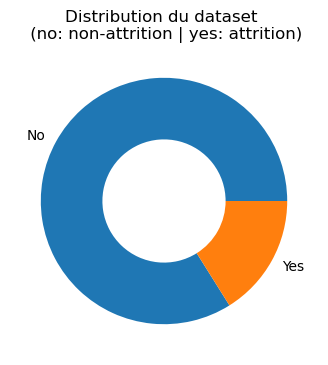

In [18]:
#Comparaison des populations des deux classes à l'aide d'un graphique
fig, ax = plt.subplots(figsize=(4, 4))
#Graphique
ax.pie(x=class_counts, 
       labels=class_counts.index, 
       wedgeprops={"width": 0.5})
#Titre
ax.set_title('Distribution du dataset \n (no: non-attrition | yes: attrition)')
#Affichage
plt.show()

In [19]:
#Affichage de la proportion des observations correspondant à une souscription
print('Les attritions représentent seulement', round(class_counts[1]/len(df) * 100,2), '% du dataset')

Les attritions représentent seulement 15.99 % du dataset


### Pour chaque variable catégorielle, affichez à l’aide un graphe adapté la proportion de churn vs. non churn

Les distributions étant très déséquilibrées, il faut créer des graphiques différents pour chaque classe. Autrement les valeurs de la classe minoritaire ne sont pas visibles.

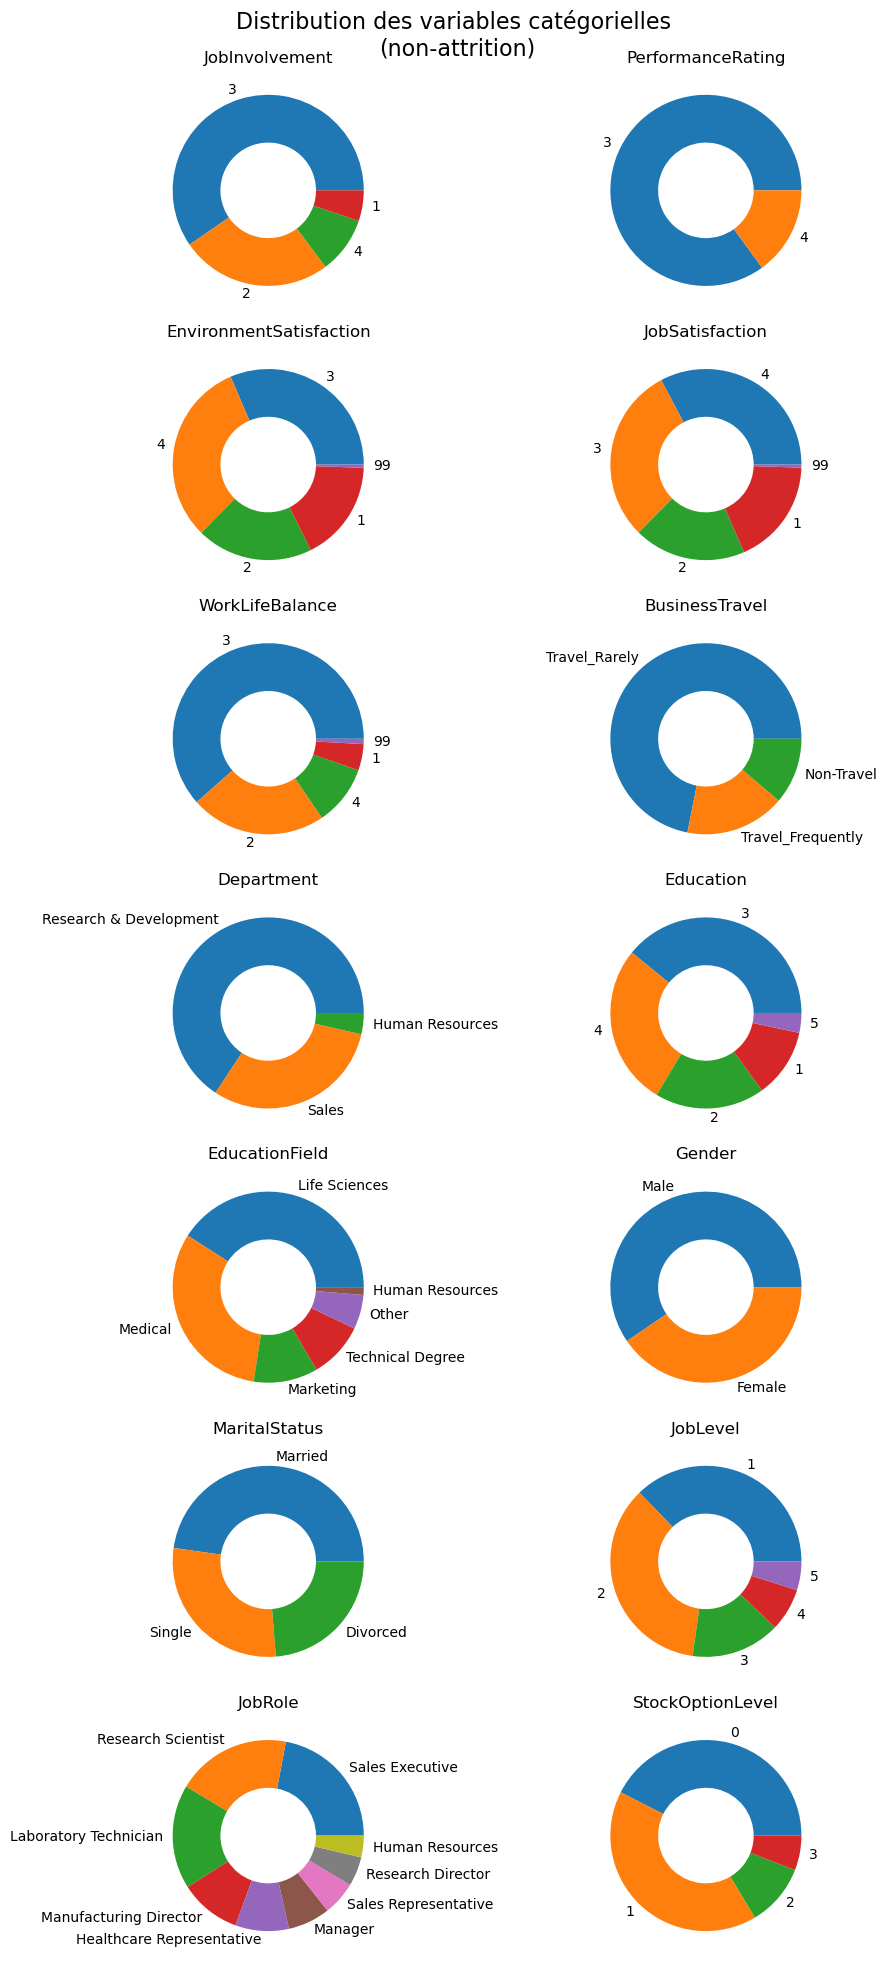

In [20]:
#Dataframe contenant uniquement les observations classées comme non-attrition
df0 = df_clean.loc[df_clean['Attrition']=='No']
df0 = df0.drop('Attrition', axis=1)

#Création d'un pie chart pour chaque variable
fig, axs = plt.subplots(7, 2, figsize=(10, 20))
axe = axs.ravel()
for i, cat in enumerate(df0[var_cat]):
    ax = axe[i]
    ax.pie(x=df0[cat].value_counts(), 
           labels=df0[cat].value_counts().index,
           wedgeprops={"width": 0.5})
    ax.set_title(cat, fontsize=12)
fig.suptitle('Distribution des variables catégorielles \n(non-attrition)', fontsize=16)
#Affichage
fig.tight_layout()
plt.show()

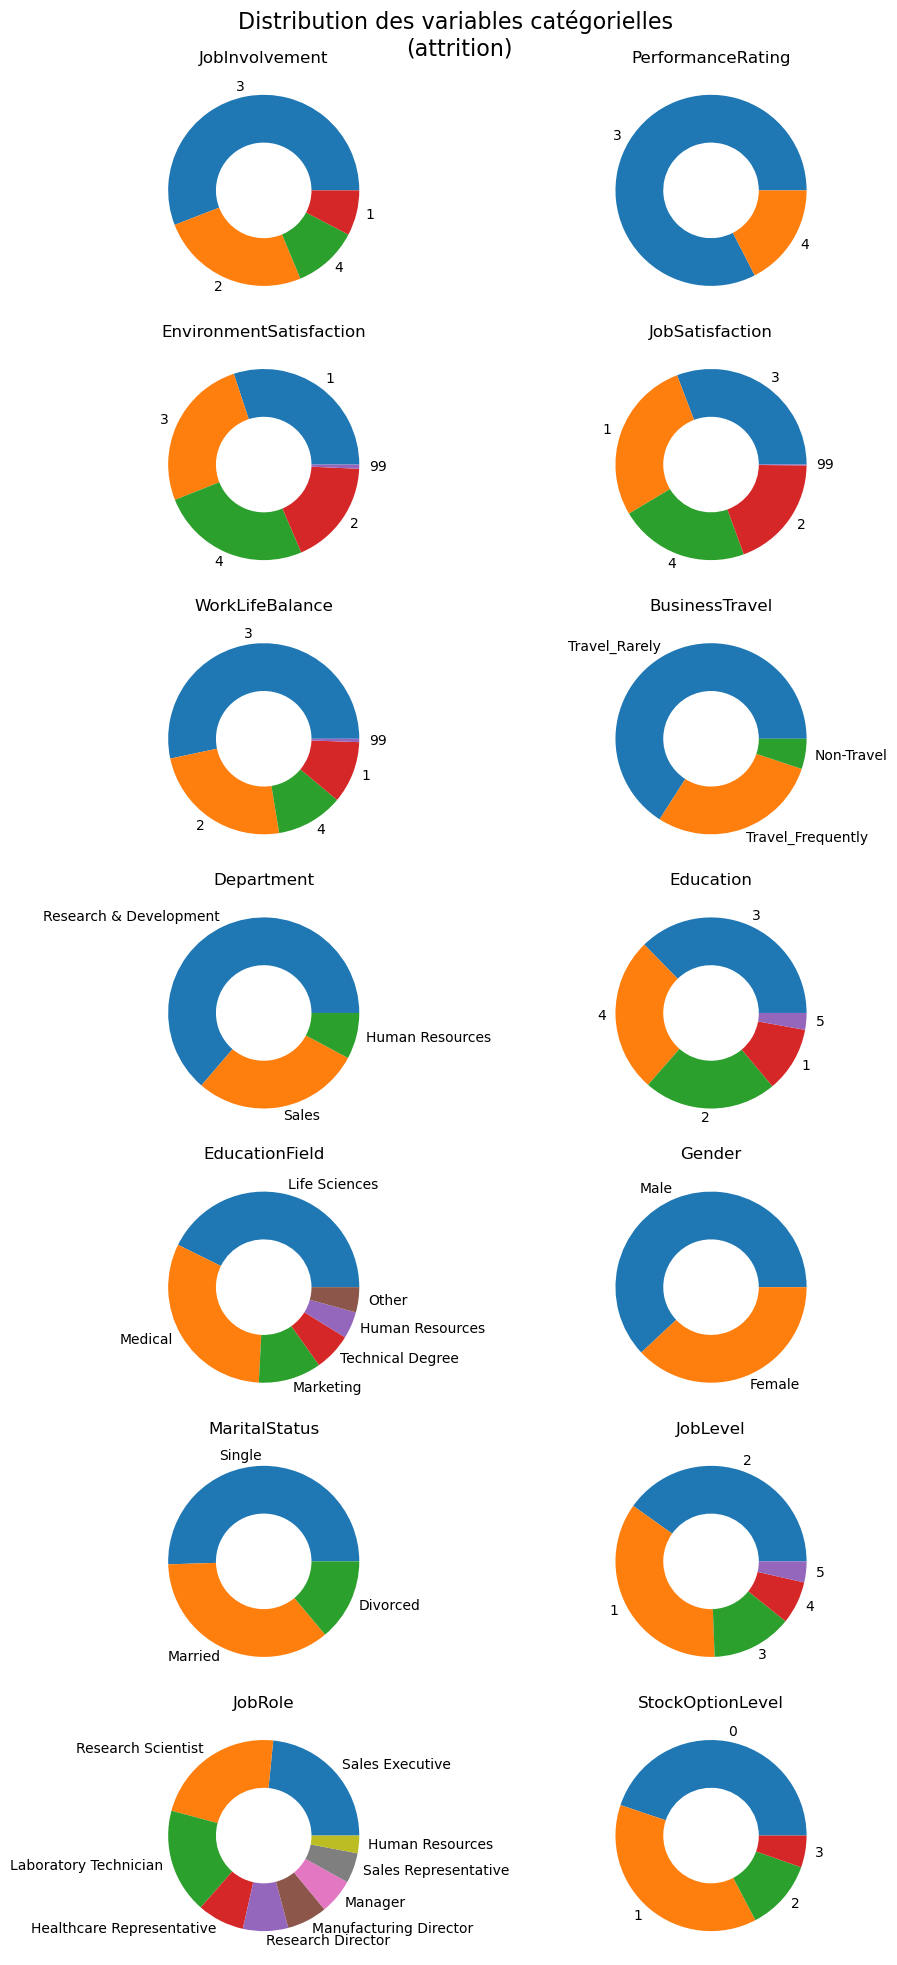

In [21]:
#Dataframe contenant uniquement les observations classées comme attrition
df1 = df_clean.loc[df_clean['Attrition']=='Yes']
df1 = df1.drop('Attrition', axis=1)

#Création d'un pie chart pour chaque variable
fig, axs = plt.subplots(7, 2, figsize=(10, 20))
axe = axs.ravel()
for i, cat in enumerate(df1[var_cat]):
    ax = axe[i]
    ax.pie(x=df1[cat].value_counts(), 
           labels=df1[cat].value_counts().index,
           wedgeprops={"width": 0.5})
    ax.set_title(cat, fontsize=12)
fig.suptitle('Distribution des variables catégorielles \n(attrition)', fontsize=16)
#Affichage
fig.tight_layout()
plt.show()

On constate que la distribution des variables EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, BusinessTravel et MaritalStatus varie selon que les observations sont classées comme attrition ou non-attrition.

### Pour chaque variable numérique, affichez séparemment à l’aide un graphe adapté (eg. histogramme) les valeurs pour les populations churn & non churn

Les distributions étant très déséquilibrées, il faut créer des graphiques différents pour chaque classe. Autrement les valeurs de la classe minoritaire ne sont pas visibles.

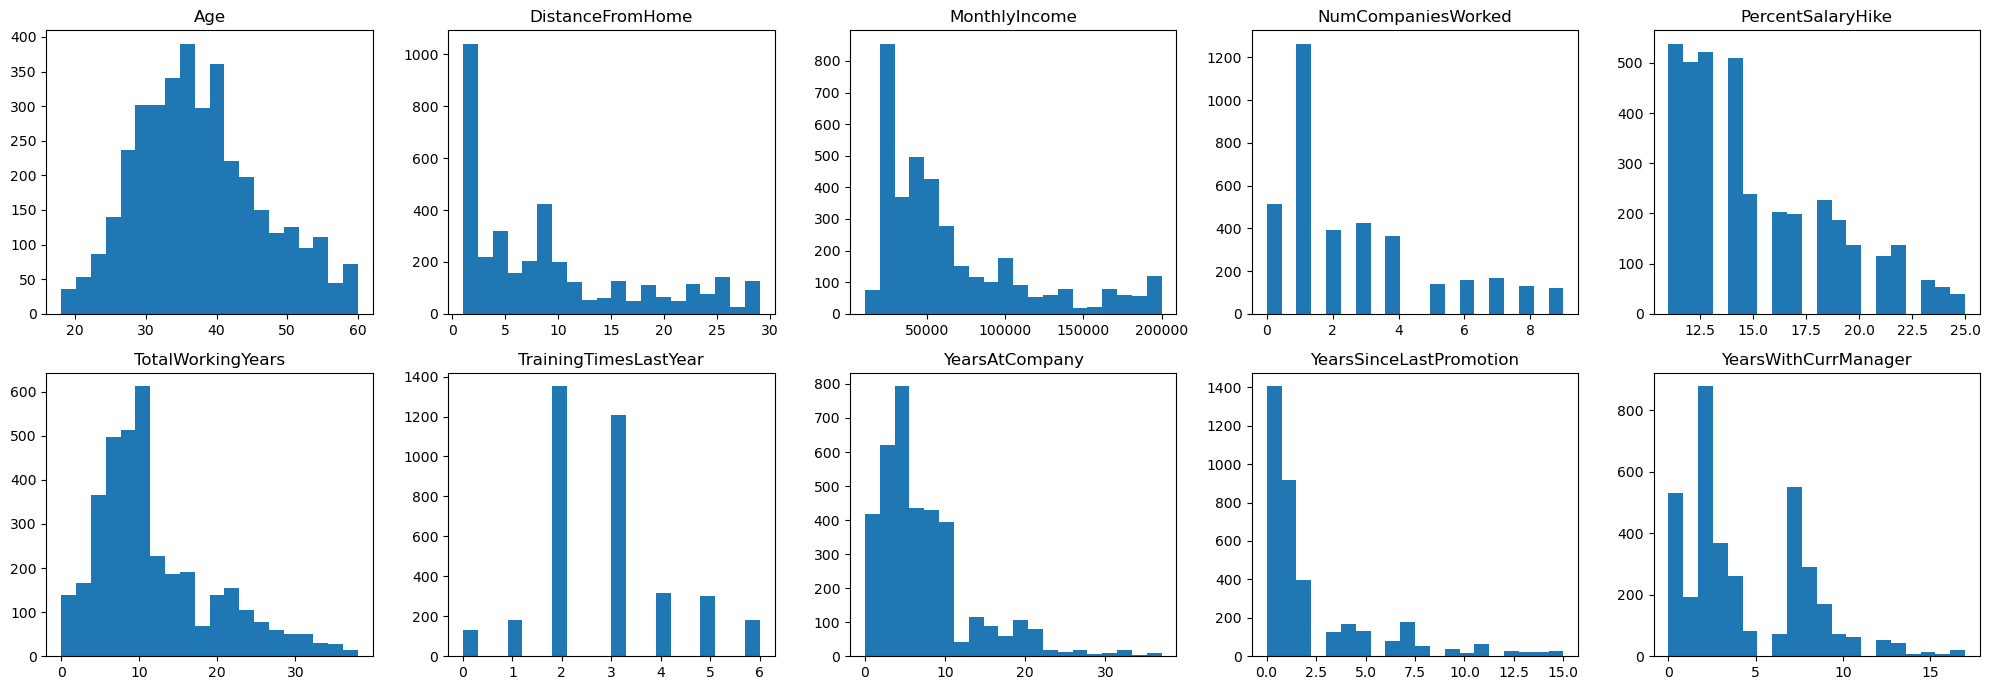

In [22]:
#Dataframe contenant uniquement les observations classées comme non-attrition
df0 = df_clean.loc[df_clean['Attrition']=='No']
df0 = df0.drop('Attrition', axis=1)

#Création des histogrammes pour les variables numériques
df0.hist(grid=False, figsize=(20,7), layout=(2,5), bins=20)
plt.tight_layout()
plt.show()

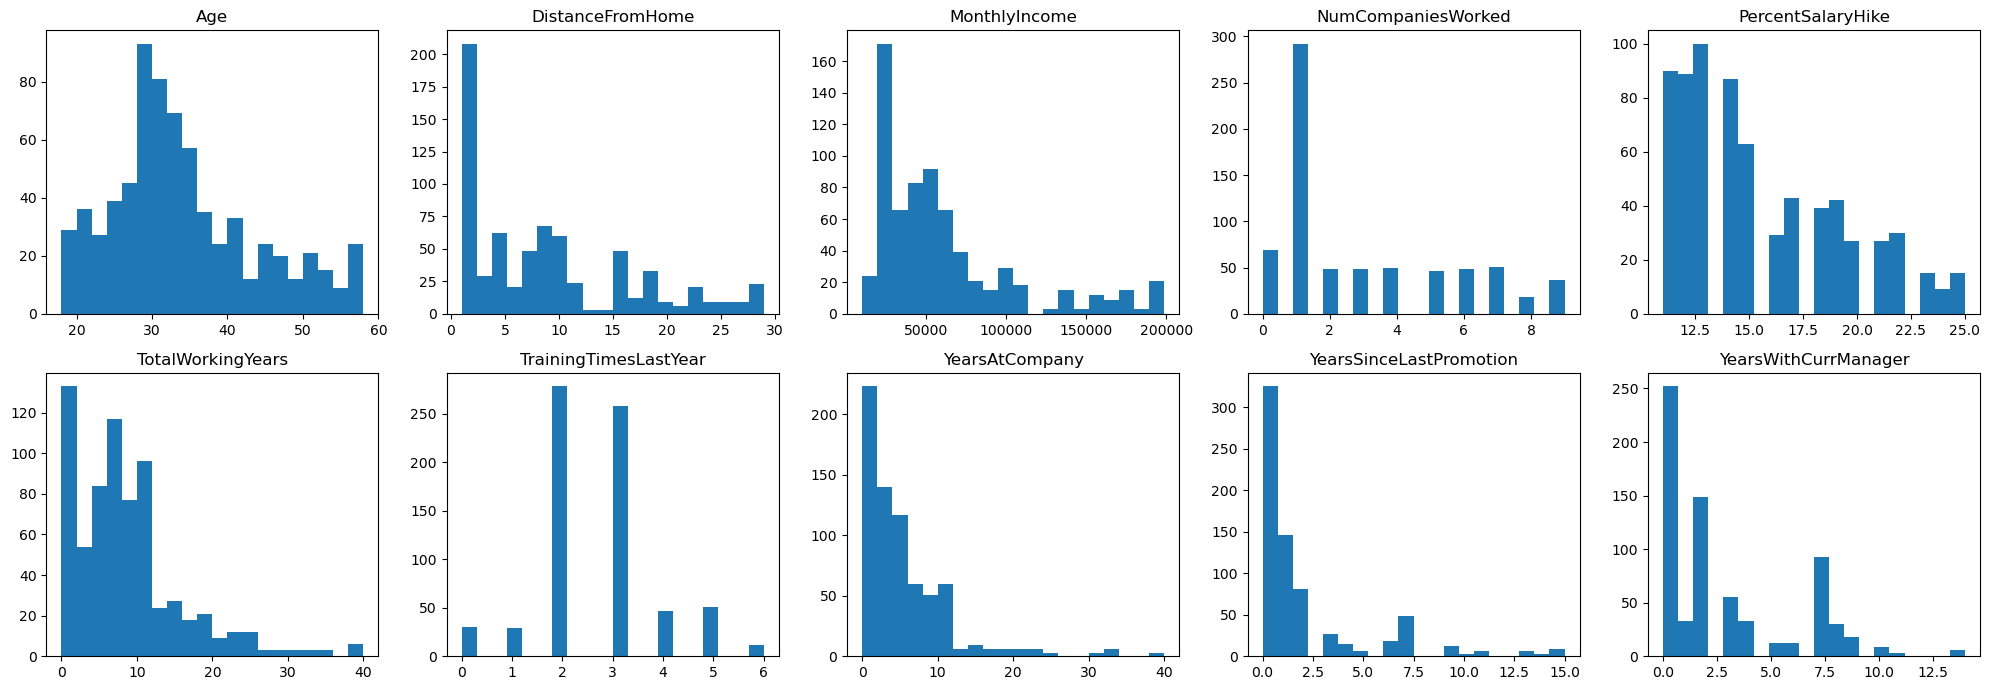

In [23]:
#Dataframe contenant uniquement les observations classées comme attrition
df1 = df_clean.loc[df_clean['Attrition']=='Yes']
df1 = df1.drop('Attrition', axis=1)

#Création des histogrammes pour les variables numériques
df1.hist(grid=False, figsize=(20,7), layout=(2,5), bins=20)
plt.tight_layout()
plt.show()

On constate que la distribution de certaines variables diffère selon que les observations sont classés comme attrition ou non. Les variables Age, TotalWorkingYears, YearsAtCompany et YearsWithCurrManager semblent plus intéressantes. Seule la variable Age a une distribution gaussienne, en forme de cloche.

Les boîtes à moustaches (boxplot) sont utiles pour détecter la présence d'outliers. La variable MonthlyIncome n'étant pas à la même échelle que les autres, son boxplot doit être affiché à part.

MonthlyIncome    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

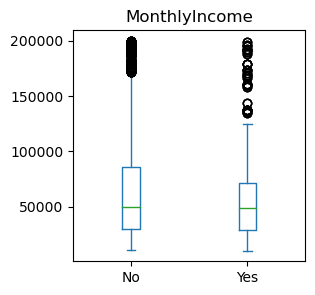

In [24]:
#Affichage du bloxpot de la variable Amount
df_clean.plot.box(column='MonthlyIncome', by='Attrition', figsize=(3,3))

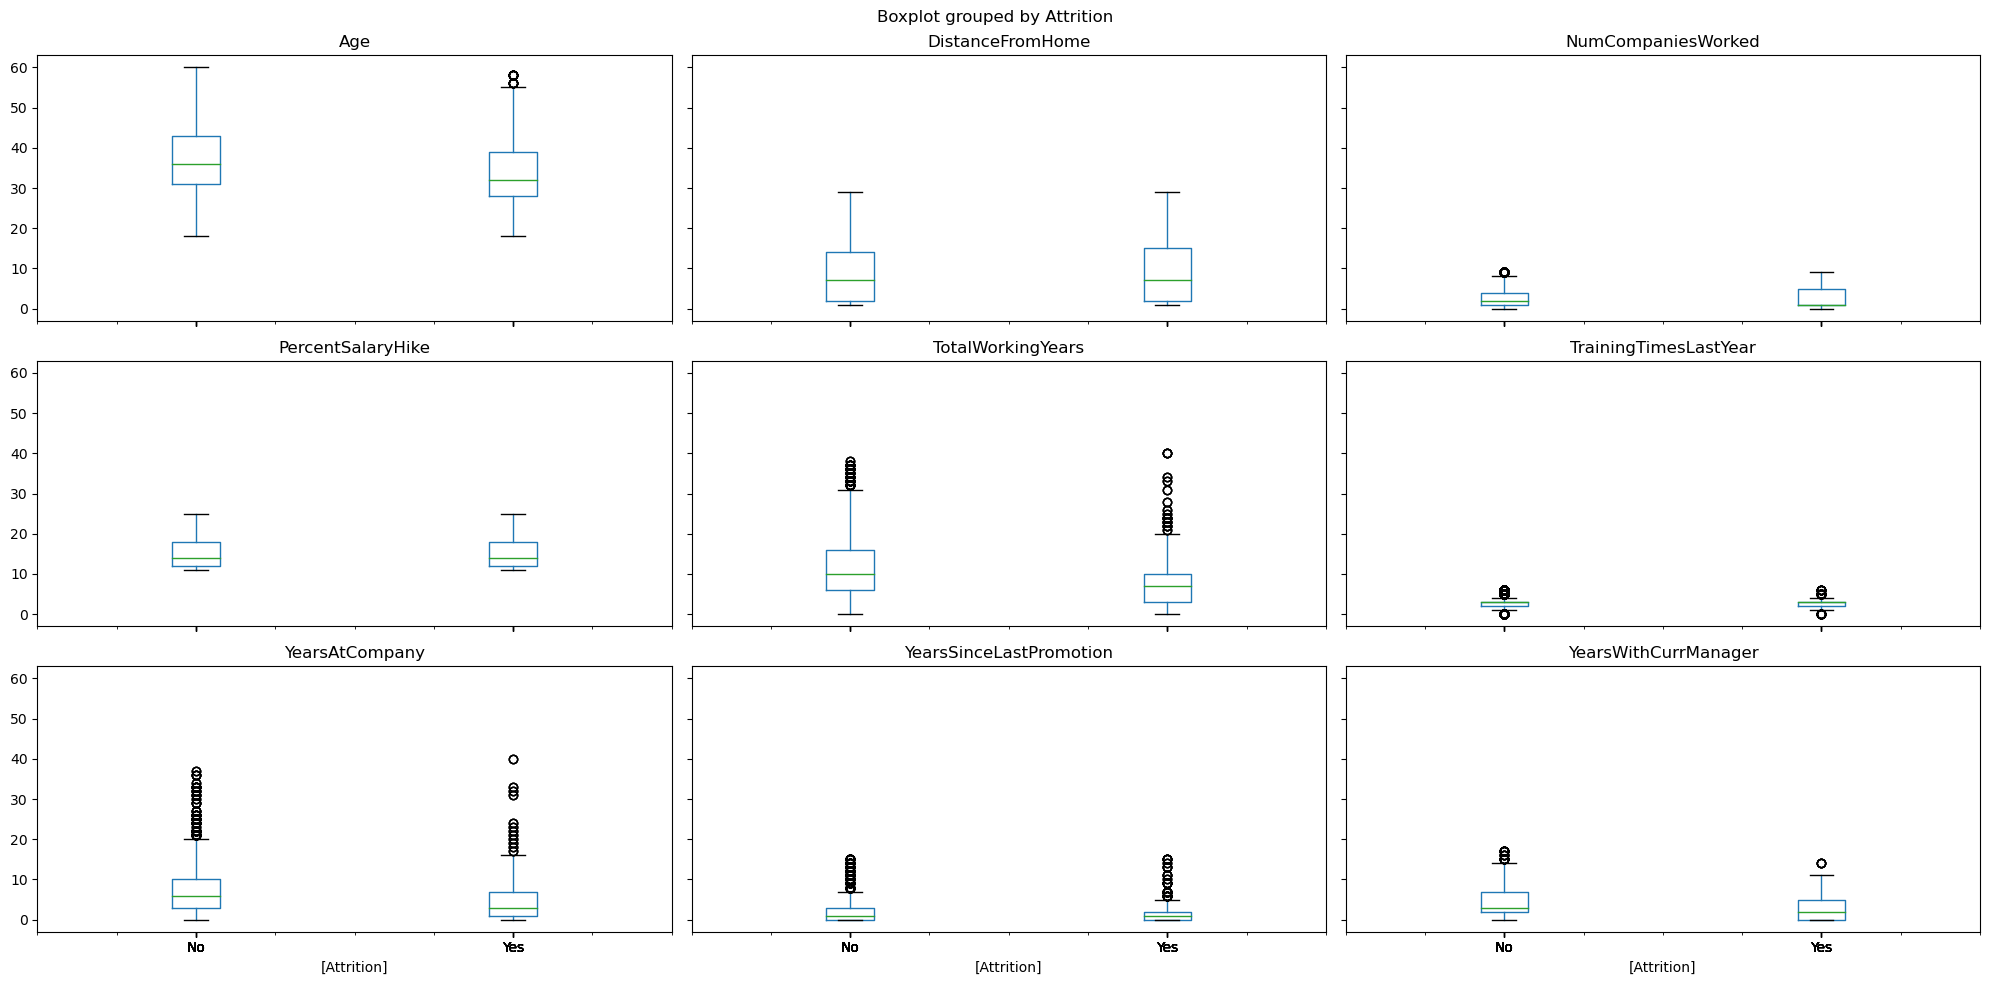

In [25]:
#Création d'un dataframe spécifique pour le boxplot des variables quantitatives (hormis MonthlyIncome)
df_box = df_clean[var_quant + ['Attrition']].drop('MonthlyIncome', axis=1)
                  
#Affichage du boxplot
df_box.boxplot(by='Attrition', grid=False, figsize=(20,10), layout=(3,3))
plt.tight_layout()
plt.show()

On constate qu'il y a de nombreux outliers, un pré-traitement sera nécessaire pour éviter qu'ils ne biaisent les algorithmes. Une solution pourra être de transformer certaines variables quantiatives en variables catégorielles à partir des quartiles. Les autres variables devront être redimensionnées.

### Affichez la matrice de corrélation des attributs

Seules les données quantitatives peuvent être utilisées dans une matrice de corrélation. Inclure les variables catégorielles encodées numériquement serait erroné et conduirait à de fausses conclusions.

La plupart des données n'ayant pas une distribution gaussienne et présentant une tendance monotone plutôt que linéaire, il est préférable de générer la matrice de corrélation des attributs avec le coefficient de Spearman plutôt qu'avec celui de Pearson.

<AxesSubplot: >

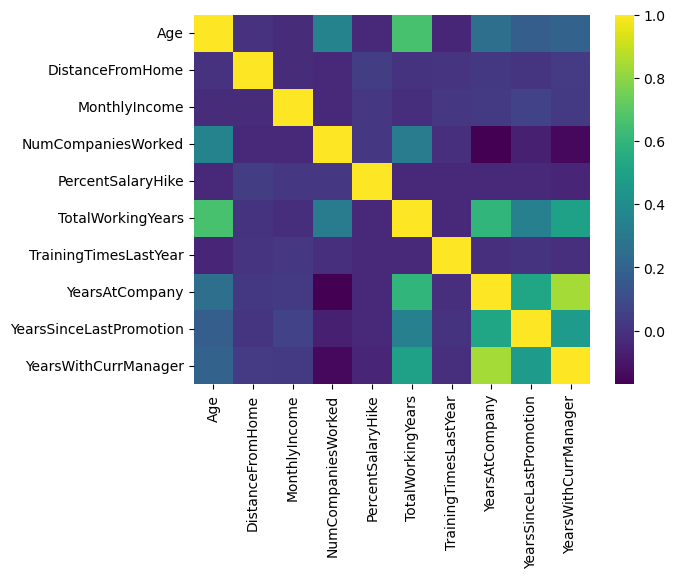

In [26]:
#Création de la matrice de corrélation avec le coefficient de Spearman
corr_matrix = df[var_quant].corr('spearman')
sns.heatmap(corr_matrix, cmap="viridis", linewidths=0)

La matrice donne une indication du degré de corrélation entre les variations de deux variables. Si deux variables évoluent dans le même sens, elles sont corrélées positivement. Si elles évoluent dans des directions opposées (l'une augmente, l'autre diminue), elles sont corrélées négativement.

Il est également utile d'utiliser une matrice de diagramme de dispersion pour repérer les relations structurées entre les variables quantitatives.

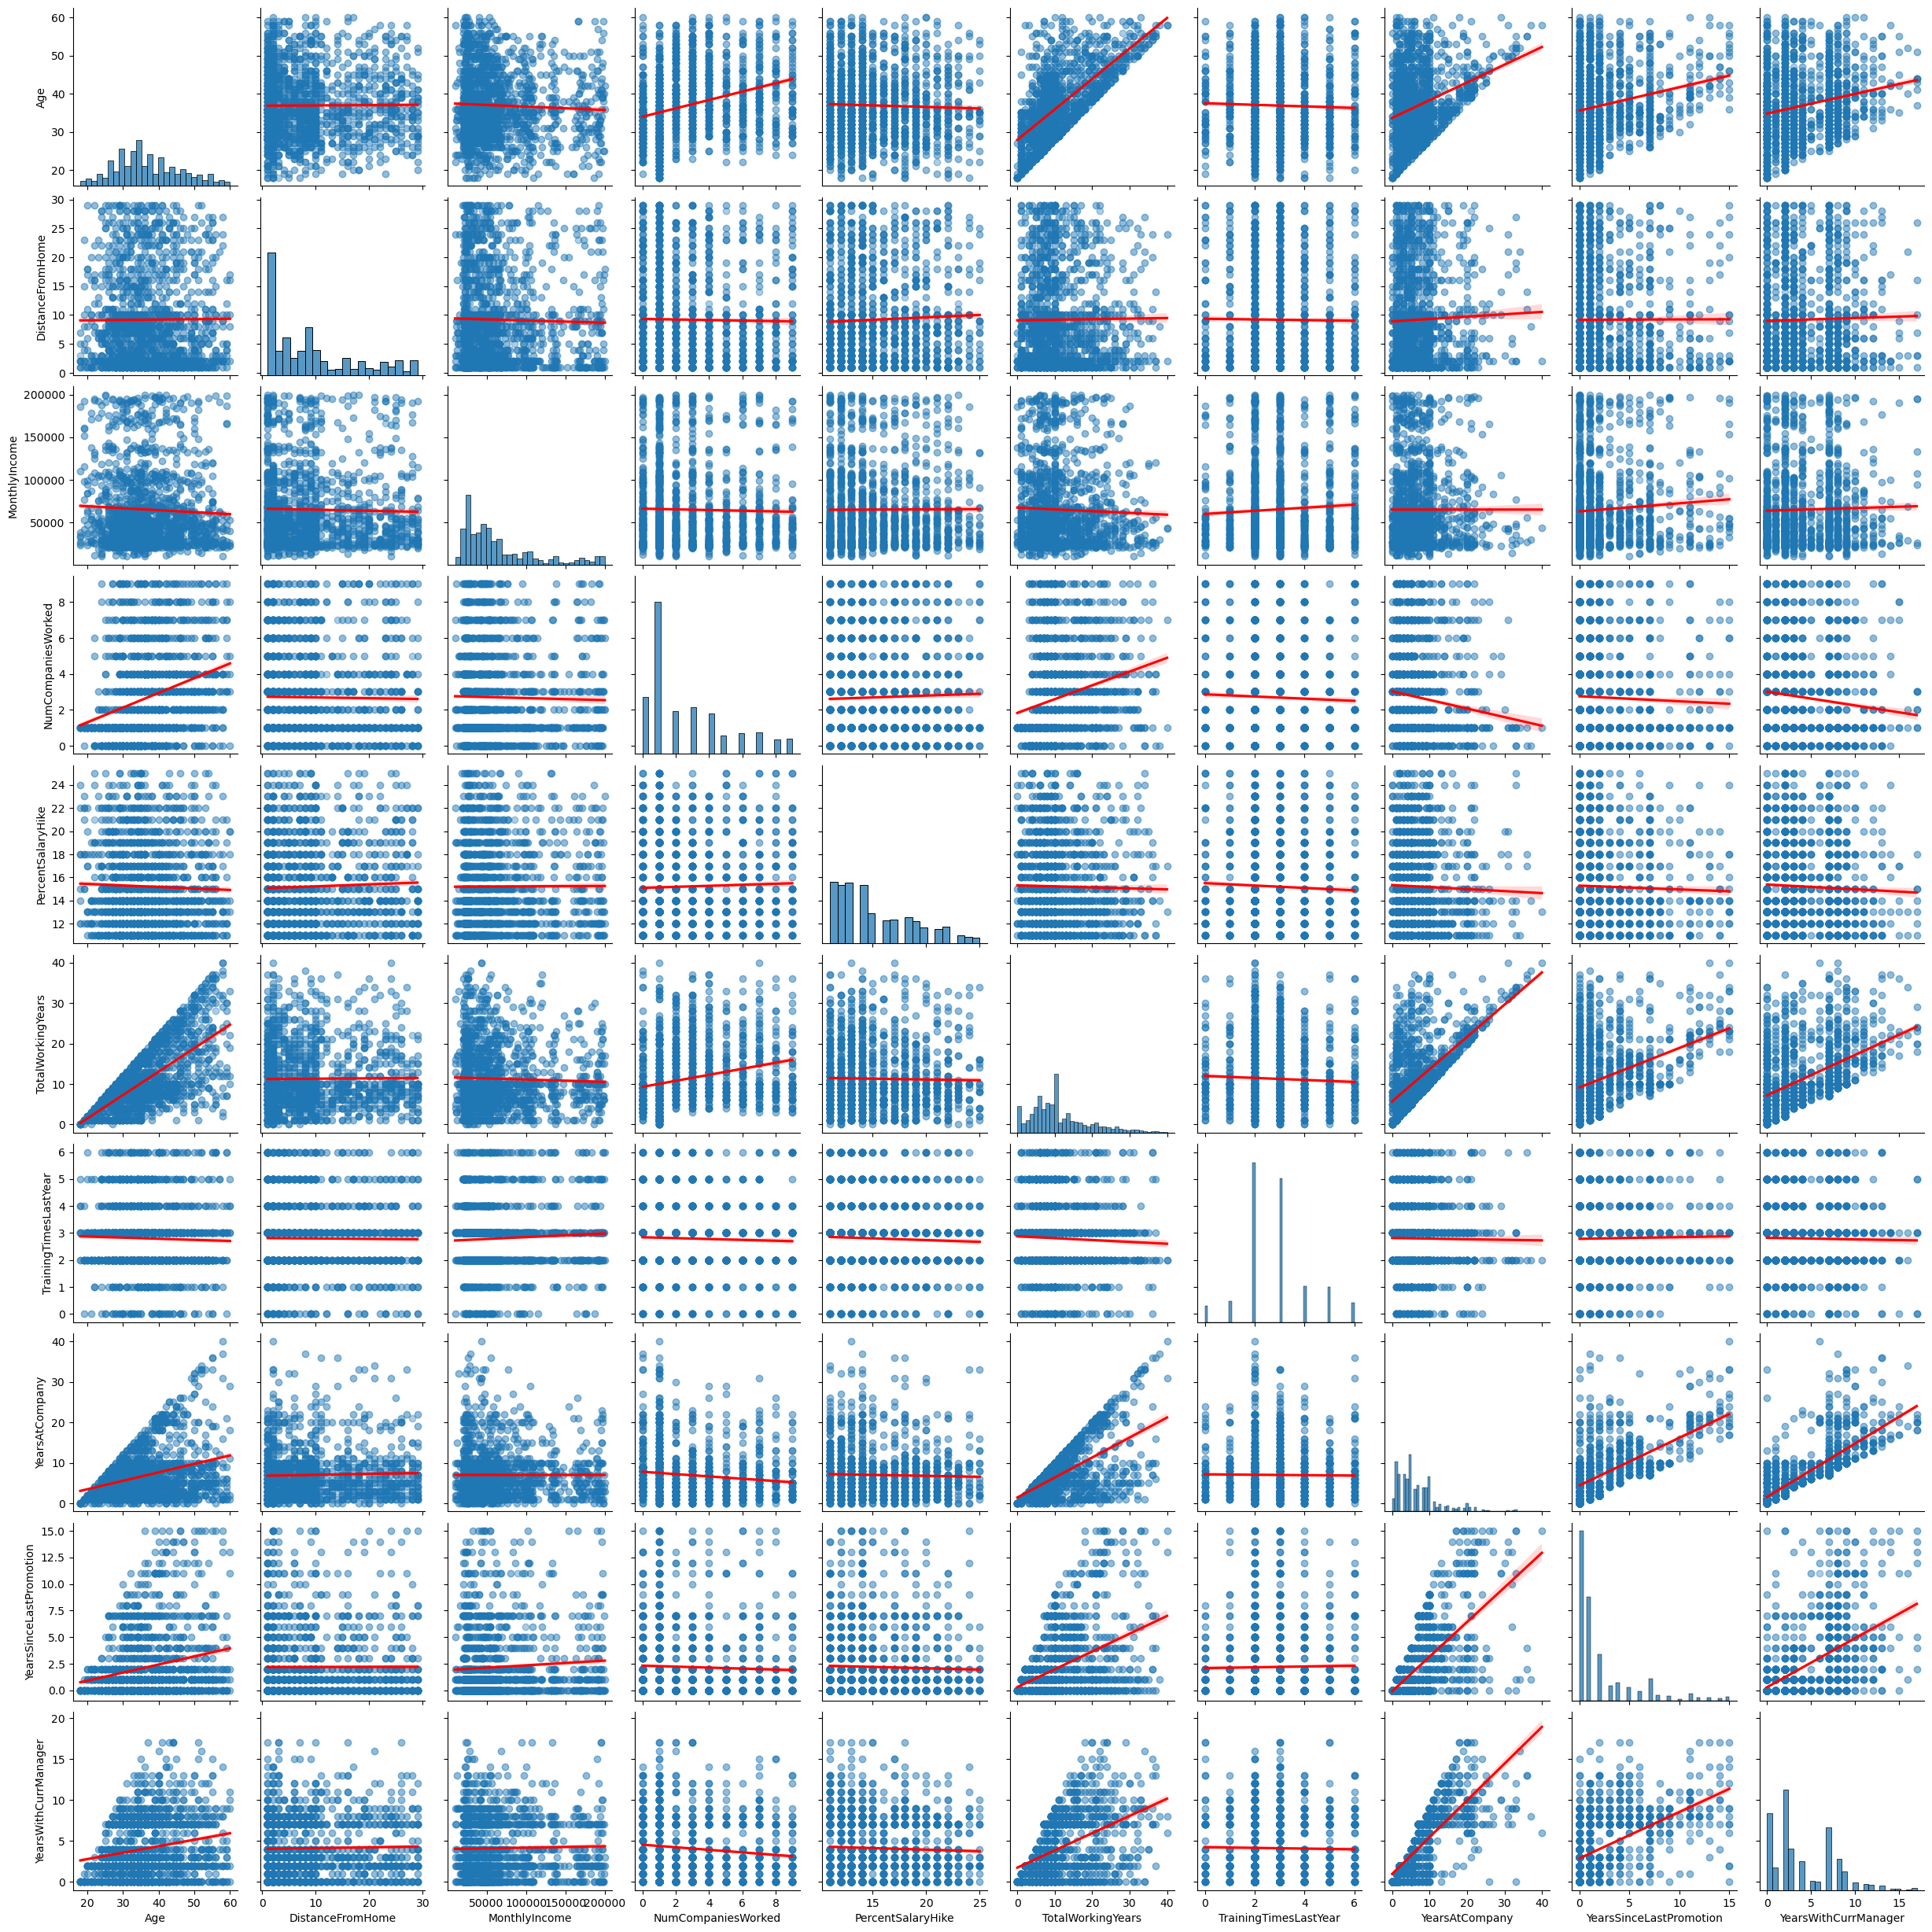

In [27]:
#Création d'une matrice de dispersion
sns.pairplot(df_clean[var_quant], kind="reg", 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2}})

On constate que certaines variables sont corrélées, par exemple Age, NumCompaniesWorked, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion et YearsWithCurrManager. Si des variables contiennent en partie la même information l'algorithme risque d'être biaisé. Il ne faudrait conserver qu'une seule variable. Par ailleurs MonthlyIncome ne semble lié a aucune autre variable, ce qui en fait une bonne variable candidate.

Le coefficient de corrélation bisérial ponctuel mesure la relation entre une variable binaire et une variable continue.

In [28]:
#Calcul du coefficient de corrélation bisérial ponctuel
y = LabelEncoder().fit_transform(df_clean['Attrition'])

for var in var_quant:
    print(var, ss.pointbiserialr(y, df_clean[var]))

Age PointbiserialrResult(correlation=-0.15839867954096706, pvalue=5.1265982193780794e-26)
DistanceFromHome PointbiserialrResult(correlation=-0.009448638515156267, pvalue=0.5317715668018396)
MonthlyIncome PointbiserialrResult(correlation=-0.03016029380846067, pvalue=0.045890862744719166)
NumCompaniesWorked PointbiserialrResult(correlation=0.04283056724472087, pvalue=0.004572057121620842)
PercentSalaryHike PointbiserialrResult(correlation=0.03315303713546664, pvalue=0.028192446935106235)
TotalWorkingYears PointbiserialrResult(correlation=-0.1696699168472392, pvalue=1.1645434967091854e-29)
TrainingTimesLastYear PointbiserialrResult(correlation=-0.04758573693081734, pvalue=0.0016276603635477602)
YearsAtCompany PointbiserialrResult(correlation=-0.13300261842521538, pvalue=9.476118084840815e-19)
YearsSinceLastPromotion PointbiserialrResult(correlation=-0.03142315056330998, pvalue=0.03752293607394324)
YearsWithCurrManager PointbiserialrResult(correlation=-0.1546915369028727, pvalue=7.10536964

Les p-values indiquent que les variables quantitatives et la classe ne sont pas indépendantes. Les coefficients de corrélation étant autour de 0, les variables sont peu corrélées avec la classe. En recoupant avec les observations des matrice de corrélation et de dispersion Age et MonthlyIncome semblent être les meilleures candidates.

Pour les variables catégorielles d'autres mesures doivent être utilisées. Le V de Cramer indique le degré d'association entre deux variables nominales. La matrice de Kendall Tau indique le degré de corrélation entre des variables ordinales.

In [29]:
#Conversion des valeurs des variables qualitatives codées en texte en entier
encoder = LabelEncoder()
for var in var_nom:
    df_clean[var] = encoder.fit_transform(df_clean[var])

#Calcul des V de Cramer
cols = var_nom + ['Attrition']
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

#Création d'une matrice
pd.DataFrame(corrM, index=cols, columns=cols)

Department  Education  EducationField    Gender   JobRole  \
Department        0.000000   0.015632        0.589624  0.000000  0.037727   
Education         0.015632   0.000000        0.051279  0.034401  0.064626   
EducationField    0.589624   0.051279        0.000000  0.026748  0.037172   
Gender            0.000000   0.034401        0.026748  0.000000  0.033808   
JobRole           0.037727   0.064626        0.037172  0.033808  0.000000   
MaritalStatus     0.047066   0.006423        0.052968  0.031692  0.064877   
Attrition         0.078385   0.019288        0.096660  0.008906  0.062303   

                MaritalStatus  Attrition  
Department           0.047066   0.078385  
Education            0.006423   0.019288  
EducationField       0.052968   0.096660  
Gender               0.031692   0.008906  
JobRole              0.064877   0.062303  
MaritalStatus        0.000000   0.175947  
Attrition            0.175947   0.000000

Cette matrice indique les variables qui sont corrélées entre elles et qui ont donc potentiellement un lien. C'est le cas des variables EducationField et Department: en toute logique les différents services de l'entreprise recrutent des profils issus de filières spécifiques. Ces variables sont redondantes. En outre EducationField est davantage lié à d'autres variables (Education, JobRole par exemple), elles mêmes moins liées avec la classe à prédire. EducationField contient donc une partie de l'information portée par ces variables.

Les variables MaritalStatus et EducationField sont les plus corrélées à la classe à prédire et semblent être de bonnes variables candidates pour nos modèles.

In [30]:
#Conversion des valeurs de la variable BusinessTravel
df_clean['BusinessTravel'] = df_clean['BusinessTravel'].replace(
    ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'], [0,1,2])

#Encodage de la variable à prédire: no=0, yes=1
df_clean['Attrition'] = LabelEncoder().fit_transform(df_clean['Attrition'])

#Encodage des variables ordinales
encoder = OrdinalEncoder(categories=[[0,1,2,3,4,5]], 
                         handle_unknown='use_encoded_value',
                         unknown_value=99)
for var in var_ord:
    df_clean[[var]] = encoder.fit_transform(df_clean[[var]])
    
#Matrice de corrélation de Kendall Tau
df_clean[var_ord + ['Attrition']].corr('kendall')

JobInvolvement  PerformanceRating  \
JobInvolvement                 1.000000           0.007435   
PerformanceRating              0.007435           1.000000   
EnvironmentSatisfaction        0.016314           0.015336   
JobSatisfaction                0.008956           0.043111   
WorkLifeBalance               -0.016574          -0.021099   
BusinessTravel                 0.027236          -0.016761   
JobLevel                      -0.017306           0.007212   
StockOptionLevel               0.013640          -0.028121   
Attrition                     -0.011214           0.024780   

                         EnvironmentSatisfaction  JobSatisfaction  \
JobInvolvement                          0.016314         0.008956   
PerformanceRating                       0.015336         0.043111   
EnvironmentSatisfaction                 1.000000         0.000673   
JobSatisfaction                         0.000673         1.000000   
WorkLifeBalance                         0.018554        -0.023236   
BusinessTravel                         -0.005830         0.009978   
JobLevel                               -0.024839        -0.022239   
StockOptionLevel                       -0.004109         0.031233   
Attrition                              -0.084345        -0.094848   

                         WorkLifeBalance  BusinessTravel  JobLevel  \
JobInvolvement                 -0.016574        0.027236 -0.017306   
PerformanceRating              -0.021099       -0.016761  0.007212   
EnvironmentSatisfaction         0.018554       -0.005830 -0.024839   
JobSatisfaction                -0.023236        0.009978 -0.022239   
WorkLifeBalance                 1.000000        0.003528 -0.024074   
BusinessTravel                  0.003528        1.000000  0.009722   
JobLevel                       -0.024074        0.009722  1.000000   
StockOptionLevel               -0.004421       -0.001047 -0.026617   
Attrition                      -0.050009        0.122026 -0.003749   

                         StockOptionLevel  Attrition  
JobInvolvement                   0.013640  -0.011214  
PerformanceRating               -0.028121   0.024780  
EnvironmentSatisfaction         -0.004109  -0.084345  
JobSatisfaction                  0.031233  -0.094848  
WorkLifeBalance                 -0.004421  -0.050009  
BusinessTravel                  -0.001047   0.122026  
JobLevel                        -0.026617  -0.003749  
StockOptionLevel                 1.000000  -0.010019  
Attrition                       -0.010019   1.000000

Les variables BusinessTravel, JobSatisfaction et EnvironmentSatisfaction sont les plus corrélées à la classe à prédire. JobSatisfaction et EnvironmentSatisfaction sont corrélées négativement, ce qui semble logique: les employés les moins satisfaits de leurs conditions de travail sont plus susceptibles de quitter l'entreprise que les autres. Ces trois variables semblent peu corrélées entre elles et sont donc de bonnes candidates.

### Que pouvez-vous déjà conclure? Y-a-t’il des attributs qui semblent être fortement liés au comportement de churn?

En observant la matrice de corrélation et la matrice de diagramme de dispersion on voit que certaines valeurs semblent avoir une relation strucurée. Si parmi les variables explicatives qui semblent liées on élimine celles qui sont le moins corrélées avec la classe à prédire, il reste sept variables : Age, MonthlyIncome, MaritalStatus, EducationField, BusinessTravel, JobSatisfaction et EnvironmentSatisfaction.

On peut confronter nos déductions avec une analyse d'information mutuelle (Mutual Information).

In [31]:
#Séparation du dataset
X = df_clean.drop('Attrition', axis=1)
y = df_clean['Attrition']

#Sélection des 7 variables les plus pertinentes avec Mutual Information
fs = SelectKBest(score_func=mutual_info_classif, k=7)
X_mi = fs.fit_transform(X, y)
X.columns[fs.get_support()]

Index(['Age', 'JobLevel', 'MaritalStatus', 'MonthlyIncome',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager'],
      dtype='object')

On retrouve Age, MaritalStatus et MonthlyIncome dans le top des variables. Nous avions éliminé les trois autres car elles sont fortement corrélées avec Age.

Notre expertise ne nous permet pas d'appuyer cette analyse exploratoire et de discriminer certaines variables. Nous allons donc poursuivre avec toutes les variables.

In [32]:
#Enregistrement des données 
df_clean.to_csv('data/whole_data_v2.csv', index=False)